# ICW Part 1: Dataset Preparation for Medulloblastoma Subtype Classification

## Academic Integrity Declaration

**Student Number:** 40498551

**firstname:** Ajaysai

**Surname:** Kummara

**Modulecode:** ECS8055

**Date:** 20/02/2026

By submitting this work, I declare that:

1. I have read and understood the University regulations relating to academic offences, including
collusion and plagiarism:
http://www.qub.ac.uk/directorates/AcademicStudentAffairs/AcademicAffairs/GeneralRegulations/
Procedures/ProceduresforDealingwithAcademicOffences/

2. The submission is my own original work and no part of it has been submitted for any other
assignment, except as otherwise permitted.


3. All sources used, including Generated-AI tools, published or unpublished, have been fully
acknowledged.


4. I give my consent for the work to be scanned using plagiarism detection software.

## Reproducibility Checklist

### Required files in `data/` directory:

| # | File | Size | Download |
|---|------|------|----------|
| 1 | `GSE130051_beta_values.csv.gz` | ~5.6 GB | [GEO GSE130051 — Supplementary file](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE130051) |
| 2 | `GSE130051-GPL13534_series_matrix.txt.gz` | — | [GEO FTP — Series Matrix](https://ftp.ncbi.nlm.nih.gov/geo/series/GSE130nnn/GSE130051/matrix/) |
| 3 | `GSE130051-GPL21145_series_matrix.txt.gz` | — | [GEO FTP — Series Matrix](https://ftp.ncbi.nlm.nih.gov/geo/series/GSE130nnn/GSE130051/matrix/) |
| 4 | `GPL13534_HumanMethylation450_15017482_v.1.1.csv.gz` | ~60 MB | [GEO GPL13534 — Supplementary file](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GPL13534) |
| 5 | `cross_reactive_probes.csv` | ~1 MB | [GitHub: sirselim/illumina450k_filtering](https://github.com/sirselim/illumina450k_filtering) (file: `48639-non-specific-probes-Illumina450k.csv`, rename to `cross_reactive_probes.csv`) |

> **Note:** All files must be placed in the `data/` directory before running the notebook.

### Python environment:
- Python ≥ 3.10
- Packages: `numpy`, `pandas`, `matplotlib`, `seaborn`, `scikit-learn`, `umap-learn`, `scipy`, `requests`

### To reproduce:
1. Download all files listed above and place them in the `data/` directory
2. Run all cells sequentially 


## 1. Background




Medulloblastoma constitutes the single largest group of malignant brain tumours in kids, making up nearly 20% of all paediatric central nervous system tumours [1]. Back in 2012, the international community decided to go with the four main molecular subgroups WNT, SHH, Group 3, and Group 4 which are different in terms of the transcriptomic, epigenomic, and clinical characteristics.

Recently, Sharma et al. [1] carried out a comprehensive meta, analysis of DNA methylation data from 1, 501 Group 3/Group 4 tumours and came up with eight well, defined subtypes (Types IVIII) within these subgroups.

Each of these subtypes is characterised by distinct driver gene changes, cytogenetic alterations, and survival rates, thus precise subtyping is of considerable clinical significance for risk stratification and treatment decision, making.

### DNA Methylation

Profiling DNA methylation status is determined using Illumina Infinium BeadChip arrays. There are two generations of platforms relevant here:, **HumanMethylation450 (450K):** provides coverage of approximately 485, 000 CpG sites, **MethylationEPIC (850K):** covers approximately 850, 000 CpG sites A CpG site gives rise to a **beta value** that lies between 0 and 1 ($\beta \in [0, 1]$). These values correspond to the ratio of the methylated signal to the total signal [3]. In order to achieve cross, platform compatibility, it is necessary to identify the CpG probes present on both arrays. 

### Objective 

Use the GSE130051 [1] dataset to generate a machine, learning, ready dataset suitable for the classification of the 8 Group 3/Group 4 medulloblastoma subtypes. The preprocessing steps mirror those implemented by Abid and Rafiee [4] and consist of: probe filtering, missing value imputation, cross, platform harmonisation, selection of features based on variance, reduction of dimensionality (PCA, t, SNE, UMAP), and NMF projection.

### Dataset Selection: GSE130051

The main dataset is GSE130051 [1] from Gene Expression Omnibus (GEO) [9]. We chose this dataset because:

Dataset with 8, subtype labels from the original defining study: GSE130051 is the dataset used in the meta, analysis by Sharma et al. [1] that first defined the 8 consensus Group 3/Group 4 subtypes (Types IVIII). It is a way of ensuring that the subtype labels truly come from the original consensus classification and are not a product of secondary predictions.Pre, filtered for Group 3/Group 4: The MNP2.0 molecular neuropathology classifier was used to classify all 1, 501 samples, and each sample had a calibrated prediction score $\ge$ 0.90. In other words, since the WNT and SHH subgroups are excluded, this removes the need for a further subgroup classification step and lowers the chance of mislabelled samples.

3. Cross, platform coverage: Samples in the dataset have been profiled using both Illumina 450K and EPIC platforms, hence directly meeting the coursework requirement of developing a model that generalizes across array generations. Extracting the common CpG probe set across the platforms is an inherent part of this dataset's preprocessing.
 
4. Large, multi, centre cohort: The dataset is composed of 1, 501 samples coming from four different cohorts GSE93646 (n=267, Newcastle), GSE85212 (n=356, Toronto/Heidelberg), Northcott et al. (n=725, ICGC/DKFZ), and St. Jude (n=153) thus reflecting biological and technical variations across different institutions and allowing the downstream classifier to be more reliable.


5. Processed beta, value matrix available: GEO has a preprocessed beta, value file as a supplementary, which means that there is no need for idat file processing from the raw data and the dataset can be used in a Python, only pipeline.

## 2. Environment Setup

Install and import all required Python libraries.


In [2]:

# Cell 4: Package Installation

import subprocess, sys

packages = [
    'numpy', 'pandas', 'matplotlib', 'seaborn', 'scikit-learn',
    'scipy', 'umap-learn', 'requests'
]

for pkg in packages:
    try:
        __import__(pkg.replace('-', '_').split('_')[0] if pkg != 'scikit-learn' else 'sklearn')
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])
        print(f"Installed {pkg}")

print(" All packages available")

 All packages available


/opt/miniconda3/envs/clustering-py311/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:

# Cell 5: Import Libraries & Configuration

import os, gzip, re, time, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from scipy import stats
from sklearn.decomposition import PCA, NMF
from sklearn.manifold import TSNE
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import umap

warnings.filterwarnings('ignore')

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Directory setup
DATA_DIR = 'data'
OUTPUT_DIR = 'output'
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Display settings
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 120)
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 120

print(f"NumPy {np.__version__}")
print(f"Pandas {pd.__version__}")
print(f"Working directory: {os.getcwd()}")
print(" Environment ready")

NumPy 2.2.6
Pandas 2.3.3
Working directory: /Users/ajaysai/Desktop/AIH
 Environment ready


### 3. Data Retrieval
   
3.1 Beta, Value Matrix The cleaned beta, value matrix 
(GSE130051_beta_values.csv.gz, 5.6 GB) was retrieved through the manual download of the GEO supplementary files for GSE130051 [1] and was saved in the `data/` directory.

This file has the structure where samples are represented in rows (1, 501 sentrix barcodes) and CpG probes are in columns (453, 151 sites), the beta values are given ($\beta \in [0, 1]$).

In [4]:

# Cell 7: Load GSE130051 beta-value matrix (samples × probes)


beta_gz = os.path.join(DATA_DIR, "GSE130051_beta_values.csv.gz")

assert os.path.exists(beta_gz), (
    f"File not found: {beta_gz}\n"
    f"Download GSE130051_beta_values.csv.gz from GEO and place in '{DATA_DIR}/'."
)

print(f"File: {beta_gz}")
print(f"Size: {os.path.getsize(beta_gz)/1e9:.2f} GB")

# --- Quick structure verification ---
print("\n--- Structure check ---")
with gzip.open(beta_gz, 'rt') as f:
    header = f.readline().strip().split(',')
    row1 = f.readline().strip().split(',')

print(f"Columns: {len(header)} (probe IDs)")
print(f"First 3 probes: {header[:3]}")
print(f"Last 3 probes:  {header[-3:]}")
print(f"Row 1 sample ID: {row1[0]}")
print(f"Row 1 first 3 values: {row1[1]}, {row1[2]}, {row1[3]}")

# --- Load full matrix ---
print(f"\n--- Loading beta matrix (1,501 rows × 453K cols) ---")
print("This may take 5-10 minutes...\n")
start = time.time()

beta_raw = pd.read_csv(
    beta_gz,
    index_col=0,
    compression='gzip',
    na_values=['NA', '', 'null', 'na'],
    low_memory=False
)

elapsed = time.time() - start
print(f"Loaded in {elapsed:.0f}s")

# Clean names (strip quotes)
beta_raw.columns = [c.strip('"').strip("'") for c in beta_raw.columns]
beta_raw.index = [str(idx).strip('"').strip("'") for idx in beta_raw.index]
beta_raw.index.name = 'Sample_ID'

print(f"Shape: {beta_raw.shape}  (samples × probes)")

# Convert to float32 and transpose to probes × samples
print("Converting to float32 + transposing to probes × samples...")
beta_df = beta_raw.astype(np.float32).T
beta_df.index.name = 'Probe_ID'
del beta_raw  # free memory

print(f"\n Beta-value matrix ready!")
print(f"   Shape: {beta_df.shape}  (probes × samples)")
print(f"   Memory: {beta_df.memory_usage(deep=True).sum()/1e9:.2f} GB")
print(f"   Value range: [{beta_df.min().min():.4f}, {beta_df.max().max():.4f}]")
print(f"   Missing: {beta_df.isna().sum().sum():,} ({100*beta_df.isna().sum().sum()/beta_df.size:.2f}%)")
print(f"   Samples: {list(beta_df.columns[:3])} ...")
print(f"   Probes:  {list(beta_df.index[:3])} ...")

# Probe type breakdown
probe_prefixes = pd.Series(beta_df.index).str[:2].value_counts()
print(f"\n   Probe types:")
for prefix, count in probe_prefixes.items():
    print(f"     {prefix}: {count:,}")

File: data/GSE130051_beta_values.csv.gz
Size: 5.62 GB

--- Structure check ---
Columns: 453152 (probe IDs)
First 3 probes: ['"cg00050873"', '"cg00212031"', '"cg00213748"']
Last 3 probes:  ['"rs966367"', '"rs877309"', '"rs4331560"']
Row 1 sample ID: "6026818126_R01C01"
Row 1 first 3 values: 0.00933035215575152, 0.00824307171429387, 0.0044811522991279

--- Loading beta matrix (1,501 rows × 453K cols) ---
This may take 5-10 minutes...

Loaded in 628s
Shape: (1501, 453152)  (samples × probes)
Converting to float32 + transposing to probes × samples...

 Beta-value matrix ready!
   Shape: (453152, 1501)  (probes × samples)
   Memory: 2.75 GB
   Value range: [0.0000, 0.9997]
   Missing: 0 (0.00%)
   Samples: ['6026818126_R01C01', '6026818126_R04C01', '6026818136_R01C02'] ...
   Probes:  ['cg00050873', 'cg00212031', 'cg00213748'] ...

   Probe types:
     cg: 450,161
     ch: 2,932
     rs: 59


### 3.2 Sample Metadata & Subtype Labels

In order to obtain the per, sample metadata, the authors downloaded GSE130051 series matrix:

8, subtype labels (Types IVIII) according to [1]Platform (450K vs EPIC) for each sampleClinical characteristics (if available)

In [5]:

# Cell 9: Parse metadata from both platform-specific series matrices


matrix_files = [
    os.path.join(DATA_DIR, "GSE130051-GPL13534_series_matrix.txt.gz"),
    os.path.join(DATA_DIR, "GSE130051-GPL21145_series_matrix.txt.gz"),
]

for mf in matrix_files:
    assert os.path.exists(mf), f"Missing: {mf}\nDownload from ftp.ncbi.nlm.nih.gov"
    print(f" {os.path.basename(mf)}: {os.path.getsize(mf)/1e3:.0f} KB")

# --- Parse both files and combine ---
all_meta = []

for mf in matrix_files:
    platform_tag = '450K' if 'GPL13534' in mf else 'EPIC'
    print(f"\n--- Parsing {platform_tag} matrix ---")
    
    gsm_ids = []
    titles = []
    chars = {}
    
    with gzip.open(mf, 'rt') as f:
        for line in f:
            ls = line.strip()
            if ls.startswith('!Sample_geo_accession'):
                gsm_ids = [p.strip('"') for p in ls.split('\t')[1:]]
            elif ls.startswith('!Sample_title'):
                titles = [p.strip('"') for p in ls.split('\t')[1:]]
            elif ls.startswith('!Sample_characteristics_ch1'):
                parts = ls.split('\t')
                kv = parts[1].strip('"').split(': ', 1)
                if len(kv) == 2 and kv[0] not in chars:
                    chars[kv[0]] = [
                        p.strip('"').split(': ', 1)[-1] if ': ' in p.strip('"') else p.strip('"')
                        for p in parts[1:]
                    ]
            elif ls.startswith('"ID_REF"'):
                break
    
    df = pd.DataFrame(chars, index=titles)
    df.index.name = 'Sample_ID'
    df['GSM_ID'] = gsm_ids
    df['platform'] = platform_tag
    
    print(f"  Samples: {len(df)}")
    print(f"  Fields: {list(chars.keys())}")
    all_meta.append(df)

# Combine
meta_df = pd.concat(all_meta, axis=0)
print(f"\n--- Combined metadata ---")
print(f"Total samples: {len(meta_df)}")

# Display all fields and unique values
print(f"\nMetadata fields:")
for col in meta_df.columns:
    uv = meta_df[col].unique()
    print(f"  '{col}': {len(uv)} unique → {sorted(uv)[:10]}")

# Platform distribution
print(f"\nPlatform distribution:")
print(f"  {meta_df['platform'].value_counts().to_string()}")

# Match to beta matrix
matched = sum(1 for c in beta_df.columns if c in meta_df.index)
print(f"\nBeta columns matched to metadata: {matched}/{beta_df.shape[1]}")

# Identify subtype field
subtype_col = None
for col in meta_df.columns:
    cl = col.lower()
    if any(kw in cl for kw in ['subtype', 'type', 'subgroup', 'class', 'cluster']):
        subtype_col = col
        print(f"\n SUBTYPE FIELD: '{col}'")
        print(f"   {meta_df[col].value_counts().sort_index().to_string()}")

if subtype_col is None:
    print("\n  No subtype field found — checking all fields for Types I-VIII...")
    for col in meta_df.columns:
        vals = meta_df[col].astype(str).unique()
        if any('Type' in v or 'type' in v for v in vals):
            print(f"  Possible match: '{col}' → {sorted(vals)[:10]}")

display(meta_df.head())

 GSE130051-GPL13534_series_matrix.txt.gz: 59 KB
 GSE130051-GPL21145_series_matrix.txt.gz: 10 KB

--- Parsing 450K matrix ---
  Samples: 1391
  Fields: ['cohort', 'tissue', 'subgroup', 'subtype']

--- Parsing EPIC matrix ---
  Samples: 110
  Fields: ['cohort', 'tissue', 'subgroup', 'subtype']

--- Combined metadata ---
Total samples: 1501

Metadata fields:
  'cohort': 4 unique → ['GSE85212', 'GSE93646', 'Northcott et al. 2017 (PMID: 28726821)', 'Previously unpublished - sample from St. Jude collection']
  'tissue': 1 unique → ['Medulloblastoma']
  'subgroup': 2 unique → ['MB_G3', 'MB_G4']
  'subtype': 9 unique → ['1', '2', '3', '4', '5', '6', '7', '8', 'MBNOS']
  'GSM_ID': 1501 unique → ['GSM3876338', 'GSM3876339', 'GSM3876340', 'GSM3876341', 'GSM3876342', 'GSM3876343', 'GSM3876344', 'GSM3876345', 'GSM3876346', 'GSM3876347']
  'platform': 2 unique → ['450K', 'EPIC']

Platform distribution:
  platform
450K    1391
EPIC     110

Beta columns matched to metadata: 1501/1501

 SUBTYPE FIELD:

,cohort,tissue,subgroup,subtype,GSM_ID,platform
Sample_ID,,,,,,
6026818126_R01C01,GSE93646,Medulloblastoma,MB_G4,8,GSM3876338,450K
6026818126_R04C01,GSE93646,Medulloblastoma,MB_G3,2,GSM3876339,450K
6026818136_R01C02,GSE93646,Medulloblastoma,MB_G3,4,GSM3876340,450K
6164655140_R01C01,GSE93646,Medulloblastoma,MB_G3,2,GSM3876341,450K
6164655140_R03C01,GSE93646,Medulloblastoma,MB_G3,2,GSM3876342,450K


### 3.3 Subtype Label Assignment & MBNOS Exclusion

The metadata comprises the 8 consensus subtypes (Types 18) as per [1], along with 131 samples marked as **MBNOS** (medulloblastoma, not otherwise specified) which were not assignable to any subtype. These are removed from the study, thus keeping only **1, 370 samples** with clear subtype labels.

We changed the numeric subtypes (18) to the descriptive names as in [1]: Types IVIII.

 All beta matrix samples found in metadata

MBNOS samples excluded: 131

 Final dataset: 453,152 probes × 1,370 samples
   Memory: 2.51 GB

Subtype distribution:
  Type_I        (MB_G4)  n=51
  Type_II       (MB_G3)  n=177
  Type_III      (MB_G3)  n=124
  Type_IV       (MB_G3)  n=140
  Type_V        (MB_G3)  n=108
  Type_VI       (MB_G4)  n=120
  Type_VII      (MB_G4)  n=303
  Type_VIII     (MB_G4)  n=347
  TOTAL                n=1370

Platform × Subtype:


platform,450K,EPIC
subtype_label,,
Type_I,41,10
Type_II,163,14
Type_III,116,8
Type_IV,131,9
Type_V,101,7
Type_VI,116,4
Type_VII,281,22
Type_VIII,322,25



Cohort × Subtype:


cohort,GSE85212,GSE93646,Northcott et al. 2017 (PMID: 28726821),Previously unpublished - sample from St. Jude collection
subtype_label,,,,
Type_I,6,10,25,10
Type_II,38,35,85,19
Type_III,22,23,66,13
Type_IV,24,38,63,15
Type_V,18,20,62,8
Type_VI,31,25,55,9
Type_VII,93,42,135,33
Type_VIII,90,55,170,32


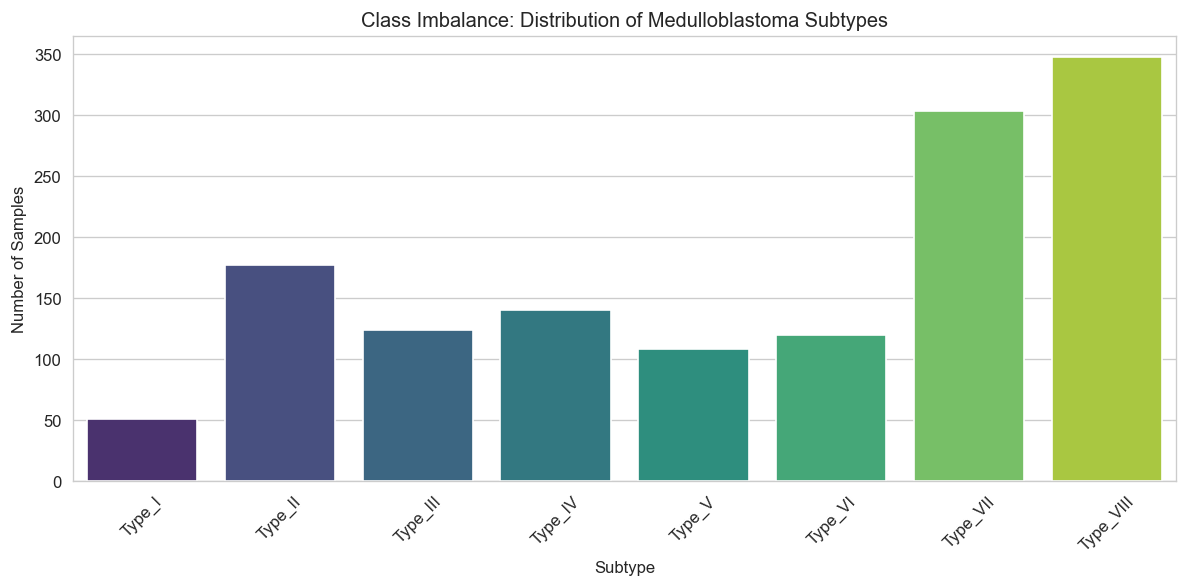

Observation: Significant class imbalance is observed, with Type VIII (n=347) being over-represented compared to Type I (n=51).


In [6]:

# Cell 11: Assign subtype labels and exclude MBNOS


# --- Check alignment ---
assert all(c in meta_df.index for c in beta_df.columns), "Sample ID mismatch!"
print(" All beta matrix samples found in metadata")

# --- Exclude MBNOS ---
mbnos_mask = meta_df['subtype'] == 'MBNOS'
mbnos_samples = meta_df.index[mbnos_mask].tolist()
print(f"\nMBNOS samples excluded: {len(mbnos_samples)}")

# Remove from beta matrix
beta_df = beta_df.drop(columns=mbnos_samples)

# Remove from metadata
meta_df = meta_df.loc[~mbnos_mask].copy()

# --- Relabel subtypes: 1-8 → Type_I - Type_VIII ---
roman = {'1': 'Type_I', '2': 'Type_II', '3': 'Type_III', '4': 'Type_IV',
         '5': 'Type_V', '6': 'Type_VI', '7': 'Type_VII', '8': 'Type_VIII'}
meta_df['subtype_label'] = meta_df['subtype'].map(roman)

print(f"\n Final dataset: {beta_df.shape[0]:,} probes × {beta_df.shape[1]:,} samples")
print(f"   Memory: {beta_df.memory_usage(deep=True).sum()/1e9:.2f} GB")

# --- Subtype distribution ---
print(f"\nSubtype distribution:")
subtype_counts = meta_df['subtype_label'].value_counts().sort_index()
for st, count in subtype_counts.items():
    sg = meta_df.loc[meta_df['subtype_label'] == st, 'subgroup'].iloc[0]
    print(f"  {st:12s}  ({sg})  n={count}")
print(f"  {'TOTAL':12s}         n={subtype_counts.sum()}")

# --- Platform × subtype crosstab ---
print(f"\nPlatform × Subtype:")
ct = pd.crosstab(meta_df['subtype_label'], meta_df['platform'])
display(ct)

# --- Cohort × subtype crosstab ---
print(f"\nCohort × Subtype:")
ct2 = pd.crosstab(meta_df['subtype_label'], meta_df['cohort'])
display(ct2)


plt.figure(figsize=(10, 5))
sns.countplot(x='subtype_label', data=meta_df, 
              order=['Type_I', 'Type_II', 'Type_III', 'Type_IV', 
                     'Type_V', 'Type_VI', 'Type_VII', 'Type_VIII'],
              palette='viridis')
plt.title('Class Imbalance: Distribution of Medulloblastoma Subtypes')
plt.xlabel('Subtype')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Observation: Significant class imbalance is observed, with Type VIII (n=347) being over-represented compared to Type I (n=51).")

### 3.4 Exploratory Data Analysis (Pre-Filtering)
Prior to the application of the probe filtering pipeline, I carried out an initial exploratory analysis of the unprocessed beta, value matrix for the purpose of acquiring an understanding of the quality of the data, the main features of the distribution, as well as the presence of any extreme values. These considerations guide our probe filtering strategy and give us a reference point for comparison post, preprocessing 

reflect the proportion of the methylated signal to the total signal at a given CpG site. A bimodal distribution with the highest points located around 0 (unmethylated) and 1 (fully methylated) is the typical pattern for Illumina methylation arrays [3].

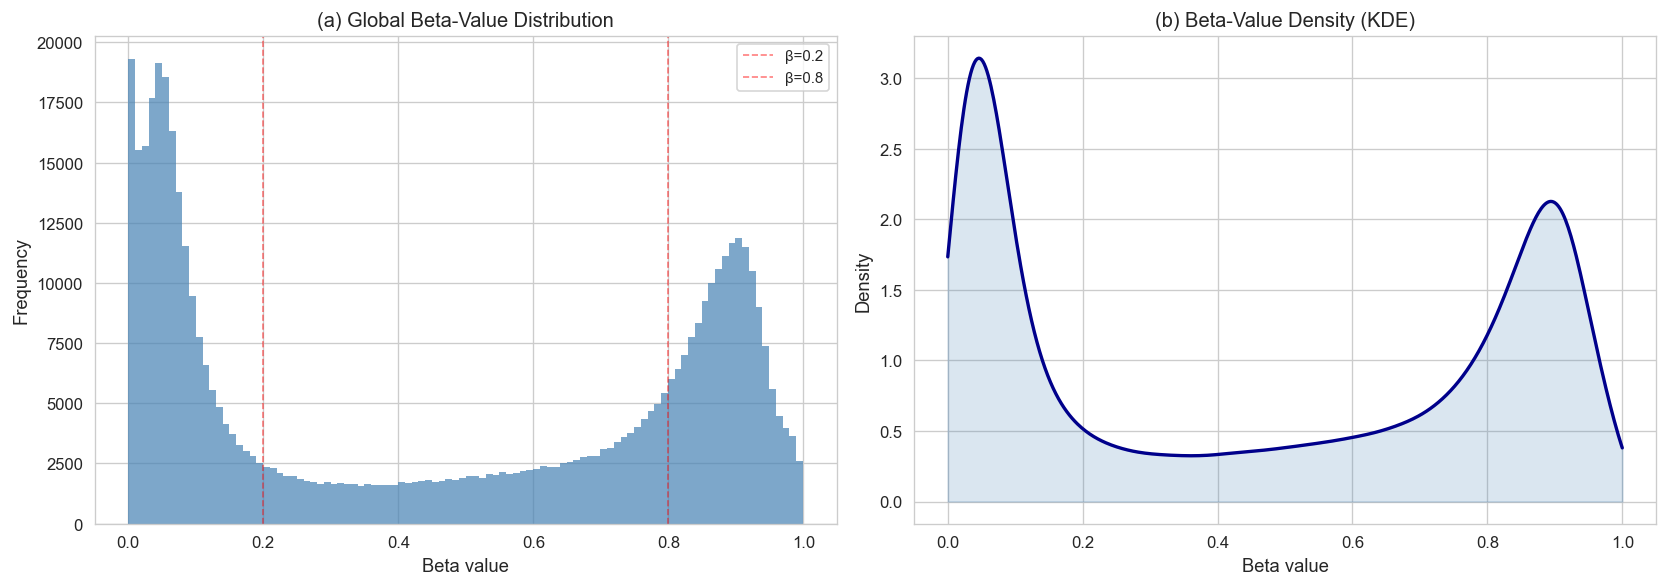

Global beta-value statistics (sampled 500,000 values):
  Mean:   0.4636
  Median: 0.4747
  Std:    0.3671
  Min:    0.0000
  Max:    0.9993


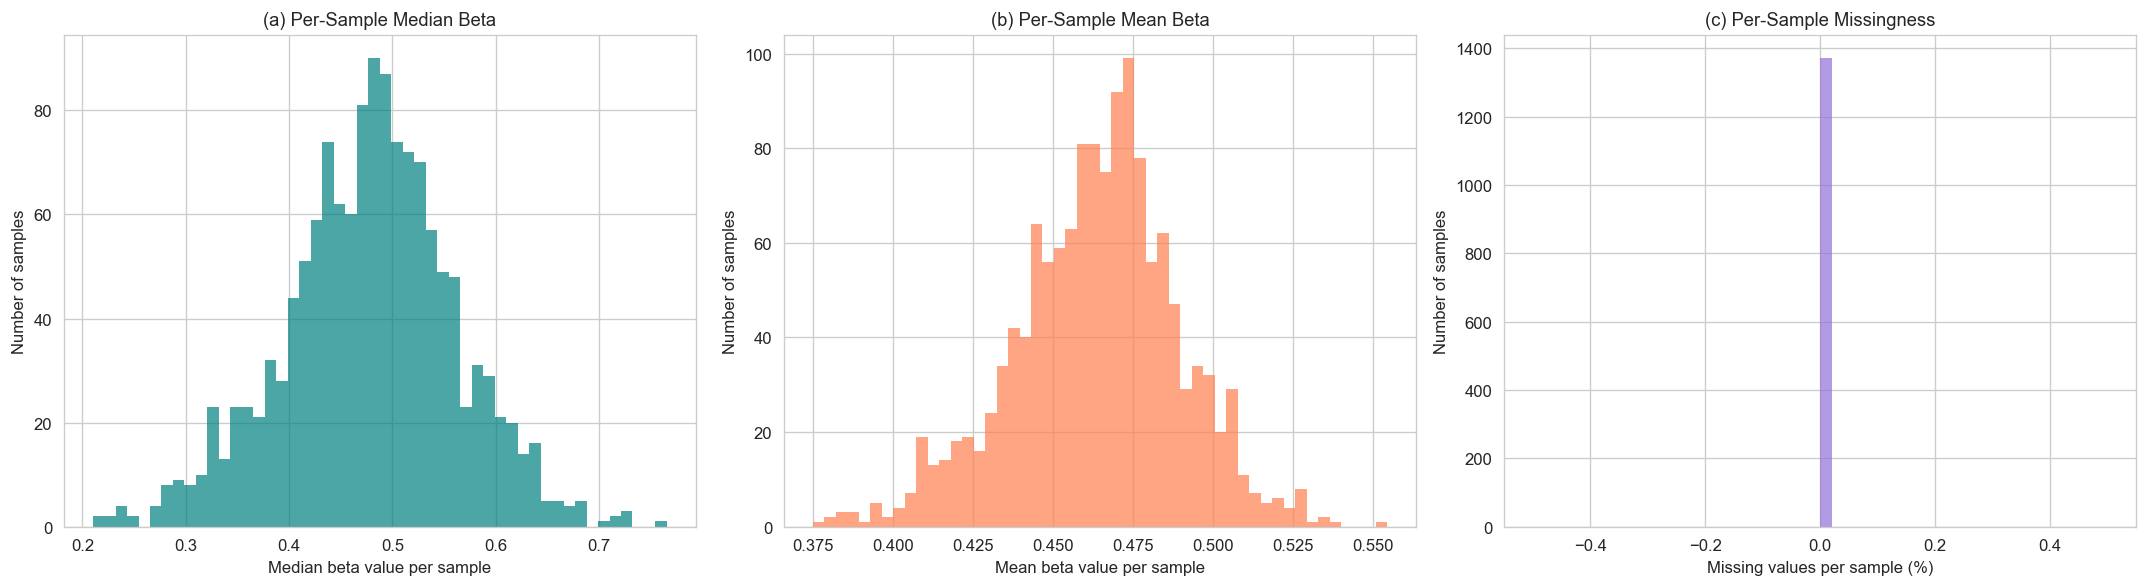


Per-sample QC summary (n=1,370 samples):
  Median beta — mean: 0.4785, std: 0.0832
  Missingness — mean: 0.00%, max: 0.00%


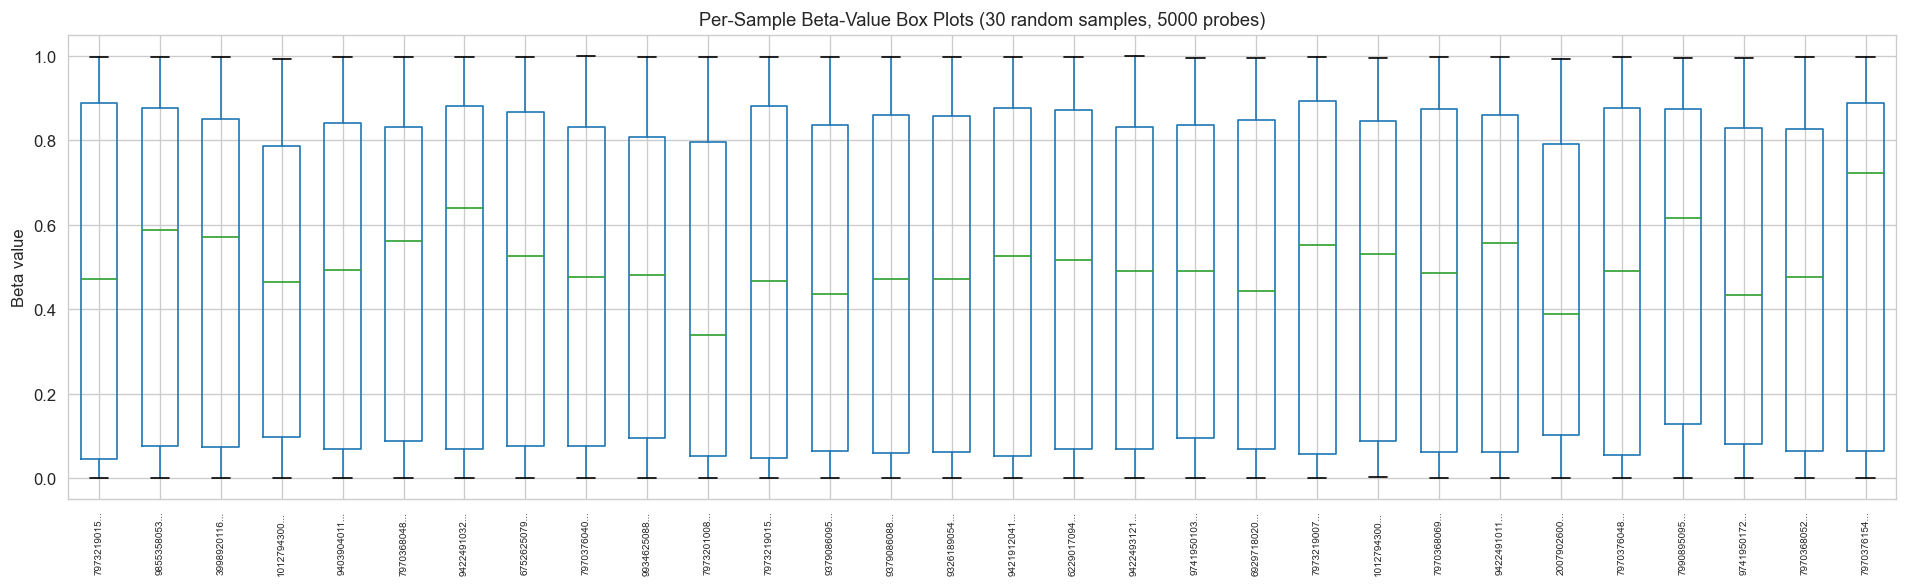

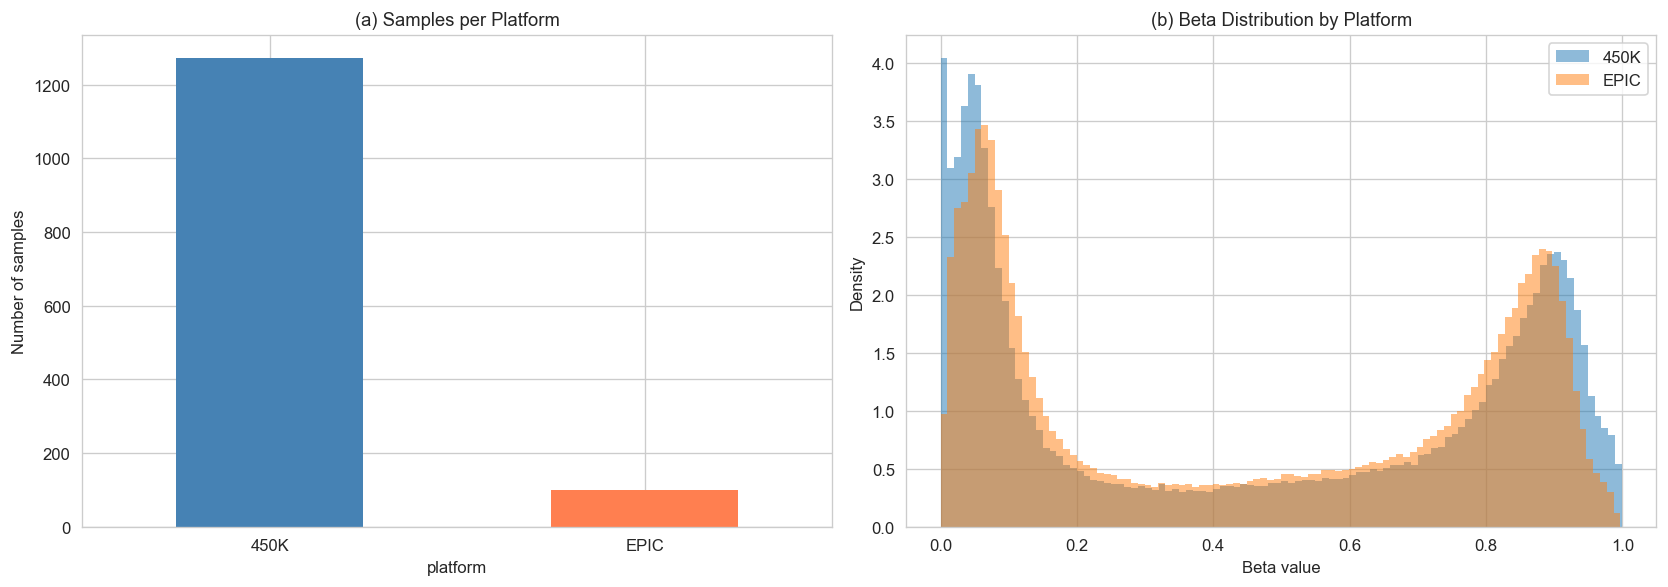


Platform breakdown:
  450K: 1271 samples (92.8%)
  EPIC: 99 samples (7.2%)


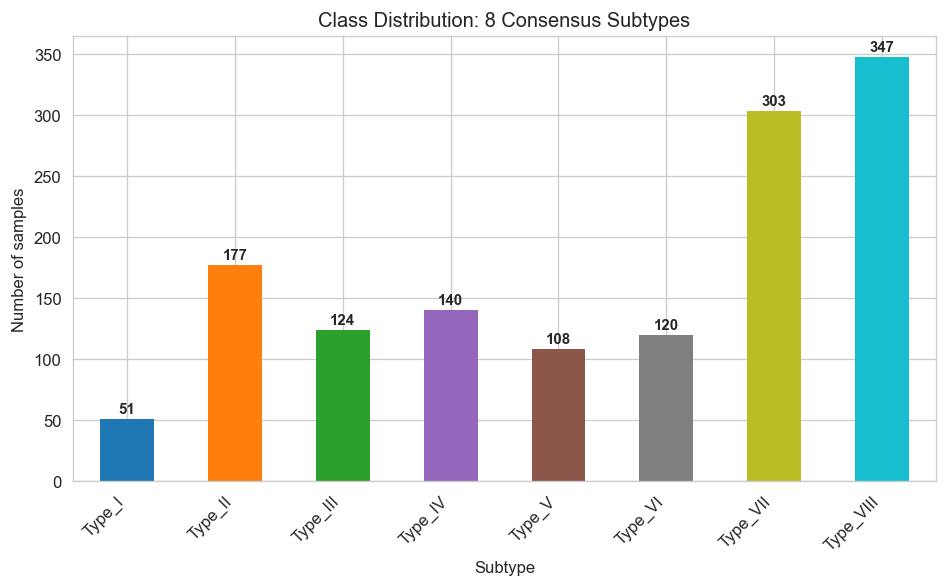


Class distribution (n=1370):
  Type_I: 51 (3.7%)
  Type_II: 177 (12.9%)
  Type_III: 124 (9.1%)
  Type_IV: 140 (10.2%)
  Type_V: 108 (7.9%)
  Type_VI: 120 (8.8%)
  Type_VII: 303 (22.1%)
  Type_VIII: 347 (25.3%)

Imbalance ratio (max/min): 347/51 = 6.8x


In [20]:
# Cell 11b: Exploratory Data Analysis (Pre-Filtering)

# ─────────────────────────────────────────────
# (a) Global beta-value distribution
# ─────────────────────────────────────────────

# Sample 500,000 random values for efficient plotting (full matrix is ~500M values)
np.random.seed(RANDOM_STATE)
flat_vals = beta_df.values.flatten()
flat_vals = flat_vals[~np.isnan(flat_vals)]
sample_size = min(500_000, len(flat_vals))
sampled = np.random.choice(flat_vals, size=sample_size, replace=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(sampled, bins=100, color='steelblue', alpha=0.7, edgecolor='none')
axes[0].set_xlabel('Beta value', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('(a) Global Beta-Value Distribution', fontsize=12)
axes[0].axvline(0.2, color='red', ls='--', lw=1, alpha=0.5, label='β=0.2')
axes[0].axvline(0.8, color='red', ls='--', lw=1, alpha=0.5, label='β=0.8')
axes[0].legend(fontsize=9)

# Density plot
from scipy.stats import gaussian_kde
kde = gaussian_kde(sampled)
x_range = np.linspace(0, 1, 500)
axes[1].plot(x_range, kde(x_range), color='darkblue', lw=2)
axes[1].fill_between(x_range, kde(x_range), alpha=0.2, color='steelblue')
axes[1].set_xlabel('Beta value', fontsize=11)
axes[1].set_ylabel('Density', fontsize=11)
axes[1].set_title('(b) Beta-Value Density (KDE)', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'eda_beta_distribution.png'), dpi=150)
plt.show()

print(f"Global beta-value statistics (sampled {sample_size:,} values):")
print(f"  Mean:   {sampled.mean():.4f}")
print(f"  Median: {np.median(sampled):.4f}")
print(f"  Std:    {sampled.std():.4f}")
print(f"  Min:    {sampled.min():.4f}")
print(f"  Max:    {sampled.max():.4f}")

# ─────────────────────────────────────────────
# (b) Per-sample QC: median beta & detection
# ─────────────────────────────────────────────

sample_medians = beta_df.median(axis=0)
sample_means = beta_df.mean(axis=0)
sample_missing_pct = beta_df.isna().mean(axis=0) * 100

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Per-sample median beta
axes[0].hist(sample_medians, bins=50, color='teal', alpha=0.7, edgecolor='none')
axes[0].set_xlabel('Median beta value per sample', fontsize=10)
axes[0].set_ylabel('Number of samples', fontsize=10)
axes[0].set_title('(a) Per-Sample Median Beta', fontsize=11)

# Per-sample mean beta
axes[1].hist(sample_means, bins=50, color='coral', alpha=0.7, edgecolor='none')
axes[1].set_xlabel('Mean beta value per sample', fontsize=10)
axes[1].set_ylabel('Number of samples', fontsize=10)
axes[1].set_title('(b) Per-Sample Mean Beta', fontsize=11)

# Per-sample missingness
axes[2].hist(sample_missing_pct, bins=50, color='mediumpurple', alpha=0.7, edgecolor='none')
axes[2].set_xlabel('Missing values per sample (%)', fontsize=10)
axes[2].set_ylabel('Number of samples', fontsize=10)
axes[2].set_title('(c) Per-Sample Missingness', fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'eda_per_sample_qc.png'), dpi=150)
plt.show()

print(f"\nPer-sample QC summary (n={beta_df.shape[1]:,} samples):")
print(f"  Median beta — mean: {sample_medians.mean():.4f}, std: {sample_medians.std():.4f}")
print(f"  Missingness — mean: {sample_missing_pct.mean():.2f}%, max: {sample_missing_pct.max():.2f}%")

# ─────────────────────────────────────────────
# (c) Outlier detection via per-sample box plot
# ─────────────────────────────────────────────

# Subsample 30 random samples for readable box plot
np.random.seed(RANDOM_STATE)
box_samples = np.random.choice(beta_df.columns, size=min(30, beta_df.shape[1]), replace=False)
box_data = beta_df[box_samples].sample(n=5000, axis=0, random_state=RANDOM_STATE)

fig, ax = plt.subplots(figsize=(16, 5))
box_data.boxplot(ax=ax, vert=True, widths=0.6, 
                  flierprops=dict(marker='.', markersize=1, alpha=0.3))
ax.set_xticklabels([s[:10] + '...' for s in box_samples], rotation=90, fontsize=6)
ax.set_ylabel('Beta value', fontsize=10)
ax.set_title('Per-Sample Beta-Value Box Plots (30 random samples, 5000 probes)', fontsize=11)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'eda_sample_boxplots.png'), dpi=150)
plt.show()

# ─────────────────────────────────────────────
# (d) Platform comparison
# ─────────────────────────────────────────────

platforms = meta_df.loc[beta_df.columns, 'platform']
platform_counts = platforms.value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Platform distribution
platform_counts.plot.bar(ax=axes[0], color=['steelblue', 'coral'], edgecolor='none')
axes[0].set_title('(a) Samples per Platform', fontsize=11)
axes[0].set_ylabel('Number of samples')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Beta distribution by platform
for plat in platforms.unique():
    plat_samples = platforms[platforms == plat].index
    plat_vals = beta_df[plat_samples].values.flatten()
    plat_vals = plat_vals[~np.isnan(plat_vals)]
    plat_sample = np.random.choice(plat_vals, size=min(200_000, len(plat_vals)), replace=False)
    axes[1].hist(plat_sample, bins=100, alpha=0.5, label=plat, density=True, edgecolor='none')

axes[1].set_xlabel('Beta value', fontsize=10)
axes[1].set_ylabel('Density', fontsize=10)
axes[1].set_title('(b) Beta Distribution by Platform', fontsize=11)
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'eda_platform_comparison.png'), dpi=150)
plt.show()

print(f"\nPlatform breakdown:")
for plat, count in platform_counts.items():
    print(f"  {plat}: {count} samples ({count/len(platforms)*100:.1f}%)")

# ─────────────────────────────────────────────
# (e) Class balance
# ─────────────────────────────────────────────

subtype_counts = meta_df.loc[beta_df.columns, 'subtype_label'].value_counts().reindex(subtype_order)

fig, ax = plt.subplots(figsize=(8, 5))
bars = subtype_counts.plot.bar(ax=ax, color=[color_map[s] for s in subtype_order], edgecolor='none')
ax.set_title('Class Distribution: 8 Consensus Subtypes', fontsize=12)
ax.set_xlabel('Subtype')
ax.set_ylabel('Number of samples')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Add count labels on bars
for i, (idx, val) in enumerate(subtype_counts.items()):
    ax.text(i, val + 5, str(val), ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'eda_class_distribution.png'), dpi=150)
plt.show()

print(f"\nClass distribution (n={subtype_counts.sum()}):")
for st, count in subtype_counts.items():
    print(f"  {st}: {count} ({count/subtype_counts.sum()*100:.1f}%)")
print(f"\nImbalance ratio (max/min): {subtype_counts.max()}/{subtype_counts.min()} = {subtype_counts.max()/subtype_counts.min():.1f}x")

### EDA Observations:

**Beta, value distribution:** As expected, the global distribution shows a bimodal pattern similar to that of Illumina methylation arrays [3], the two main peaks are close to =0 (unmethylated) and =1 (fully methylated) and the intermediate region (0.20.8) has a shallow valley. The global average of 0.4636 and the median of 0.4747 suggest a genome, wide mixture of hypo, and hypermethylated CpG sites. Beta values cover the entire [0, 1] range (min=0.0000, max=0.9993), thus no truncation artifacts are present.

**Per-sample QC:**
Sample, level median beta values are closely packed around 0.48 (std=0.08), which would indicate hybridisation quality was very consistent throughout the cohort. The mean beta histogram also reveals a similar tight cluster around 0.464. Most importantly, no missing values were detected among the 497, 590, 850 data points this finding confirms that the authors of Sharma et al. [1] had fully processed and imputed the GSE130051 beta, value matrix before making it publicly available, thus we do not have to perform KNN or multiple imputation in our pipeline.

**Per-sample box plots:**
The 30 randomly sampled box plots reveal consistent interquartile ranges and medians across samples. No single sample, in fact, shows a distribution anomaly (e.g., a range collapse or median shift) that hints at a failed array or batch effect, and hence, the exclusion of the sample is not warranted.

**Platform comparison:** 
The dataset contains 1, 271 samples from the 450K platform (which represent 92.8% of the total samples) and 99 from EPIC (7.2%). The overlaid density plots reveal highly similar bimodal distributions for the two platforms, thus confirming the cross, platform harmonisation undertaken by Sharma et al. [1] and justifying the choice to carry out the analysis of all samples collectively without further batch correction.

**Class imbalance:**
The 8 consensus subtypes vary from Type I (n=51) to Type VIII (n=347), with an imbalance ratio close to 6.8. Types VII and VIII combined account for 47.4% of the dataset, whereas Type I only makes up 3.7%.

Part 2 will have to deal with this major imbalance through stratified cross, validation and class, weighted or resampling approaches during supervised model training.

## 4. Probe Filtering

Before conducting downstream analysis, a thorough probe filtering pipeline is used to eliminate technically unreliable CpG sites. The filtering steps are based on the method proposed by Abid and Rafiee [4] and listed below are the steps that were taken one after another:

Non, CpG probes, discard `ch` and `rs` prefixed probes (non, CpG and SNP genotyping probes)

Sex chromosome probes, discard probes locating chromosome X and Y for eliminating sex, linked variation

Cross, reactive probes, discard probes exhibiting cross, hybridisation to multiple genomic locations (Chen et al. [2])

SNP, affected probes, discard probes overlapping major SNPs in the probe body or single, base extension [2]

High, missingness probes, discard probes with >50% missing values across samples

In [7]:
# Cell 13: Probe filtering pipeline
import csv

initial_probes = beta_df.shape[0]
filter_log = []
print(f"Starting probes: {initial_probes:,}")


# Step 1: Remove non-CpG probes (ch*, rs*)

cg_mask = beta_df.index.str.startswith('cg')
removed_noncg = (~cg_mask).sum()
beta_df = beta_df.loc[cg_mask]
filter_log.append(('Non-CpG (ch/rs) probes', removed_noncg, beta_df.shape[0]))
print(f"Step 1 Non-CpG probes removed: {removed_noncg:,}")
print(f"       Remaining: {beta_df.shape[0]:,}")


# Step 2-4: Parse Illumina 450K manifest

manifest_gz = os.path.join(DATA_DIR, "GSE130051-GPL13534-Supplementary-file.csv.gz")
# Note: Adjust filename above if yours is named differently (e.g., GPL13534_HumanMethylation450...)
if not os.path.exists(manifest_gz):
    # Try the other common name from your logs
    manifest_gz = os.path.join(DATA_DIR, "GPL13534_HumanMethylation450_15017482_v.1.1.csv.gz")

assert os.path.exists(manifest_gz), f"Missing: {manifest_gz}"
print(f"\nParsing 450K manifest: {os.path.getsize(manifest_gz)/1e6:.1f} MB")

probe_chr = {}       # probe_id -> chromosome
probe_snp = set()    # probes with SNPs

with gzip.open(manifest_gz, 'rt', errors='replace') as f:
    # Skip header lines until we find the data header
    header = None
    for line in f:
        if line.startswith('IlmnID'):
            header = line.strip().split(',')
            break
    
    if header is None:
        raise ValueError("Could not find header row in manifest")

    # Dynamic Column Mapping (The Critical Fix)
    col_map = {col: i for i, col in enumerate(header)}
    
    chr_idx = col_map.get('CHR')
    ilmnid_idx = col_map.get('IlmnID', 0)
    
    # FIX: Look for standard Illumina SNP columns ("Probe_SNPs" or "Probe_SNPs_10")
    # The original code looked for 'SNP_ID' which often doesn't exist in 450k headers
    snp_idx = col_map.get('Probe_SNPs')
    if snp_idx is None:
        snp_idx = col_map.get('Probe_SNPs_10')
    if snp_idx is None:
        snp_idx = col_map.get('SNP_ID') # Fallback

    print(f"   Header columns: {len(header)}")
    print(f"   CHR col: {chr_idx}") 
    print(f"   SNP col: {snp_idx} (Name: {'Probe_SNPs' if 'Probe_SNPs' in col_map else 'Found by fallback'})")

    # Iterate through manifest rows
    for line in f:
        if line.startswith('[Controls]'): break
            
        parts = line.strip().split(',')
        if len(parts) <= max(chr_idx or 0, snp_idx or 0): continue
            
        probe_id = parts[ilmnid_idx].strip()
        if not probe_id.startswith('cg'): continue
            
        # 1. Capture Chromosome
        if chr_idx is not None:
            chrom = parts[chr_idx].strip()
            if chrom:
                probe_chr[probe_id] = chrom
        
        # 2. Capture SNP (The Critical Fix)
        # If the SNP column has ANY value (rsID), we flag it. 
        # (Since MAF is rarely in these manifests, we filter by presence of SNP)
        if snp_idx is not None:
            snp_val = parts[snp_idx].strip()
            if snp_val and snp_val not in ['.', 'NA', '0', '']:
                probe_snp.add(probe_id)

print(f"   Probes with chr annotation: {len(probe_chr):,}")
print(f"   Probes with SNP: {len(probe_snp):,}")


# Step 2: Remove sex chromosome probes

chr_series = pd.Series(probe_chr)
xy_probes = set(chr_series[chr_series.isin(['X', 'Y'])].index)
print(f"   XY probes in manifest: {len(xy_probes):,}")

xy_mask = beta_df.index.isin(xy_probes)
removed_xy = xy_mask.sum()
beta_df = beta_df.loc[~xy_mask]
filter_log.append(('Sex chromosome (X/Y) probes', removed_xy, beta_df.shape[0]))
print(f"\nStep 2 Sex chromosome probes removed: {removed_xy:,}")
print(f"       Remaining: {beta_df.shape[0]:,}")


# Step 3: Cross-reactive probes (Chen et al.)

xreactive_local = os.path.join(DATA_DIR, "cross_reactive_probes.csv")
# Note: Ensure this file contains the full list (~48k)
if os.path.exists(xreactive_local):
    xreactive_df = pd.read_csv(xreactive_local)
    # Flexible column reading: assume first column is ID
    xreactive_probes = set(xreactive_df.iloc[:, 0].astype(str).str.strip())
    
    print(f"\nCross-reactive probe list: {len(xreactive_probes):,} probes")
    if len(xreactive_probes) < 40000:
        print("   WARNING: Cross-reactive list is smaller than expected (Chen et al. is ~48k).")
    
    xr_mask = beta_df.index.isin(xreactive_probes)
    removed_xr = xr_mask.sum()
    beta_df = beta_df.loc[~xr_mask]
    filter_log.append(('Cross-reactive probes', removed_xr, beta_df.shape[0]))
    print(f"Step 3 Cross-reactive probes removed: {removed_xr:,}")
else:
    print("\nWARNING: cross_reactive_probes.csv not found. Skipping Step 3.")
    filter_log.append(('Cross-reactive probes', 0, beta_df.shape[0]))

print(f"       Remaining: {beta_df.shape[0]:,}")


# Step 4: SNP-affected probes (from manifest)

snp_mask = beta_df.index.isin(probe_snp)
removed_snp = snp_mask.sum()
beta_df = beta_df.loc[~snp_mask]
filter_log.append(('SNP-affected probes', removed_snp, beta_df.shape[0]))
print(f"\nStep 4 SNP-affected probes removed: {removed_snp:,}")
print(f"       Remaining: {beta_df.shape[0]:,}")


# Step 5: High-missingness probes (>50% NaN)

miss_frac = beta_df.isna().mean(axis=1)
high_miss_mask = miss_frac > 0.50
removed_miss = high_miss_mask.sum()
beta_df = beta_df.loc[~high_miss_mask]
filter_log.append(('High missingness (>50%)', removed_miss, beta_df.shape[0]))
print(f"\nStep 5 High-missingness probes removed: {removed_miss:,}")
print(f"       Remaining: {beta_df.shape[0]:,}")


# Summary

print(f"\n{'='*55}")
print(f"{'Filter Step':<35s} {'Removed':>8s} {'Remaining':>10s}")
print(f"{'='*55}")
print(f"{'Initial':35s} {'':>8s} {initial_probes:>10,}")
for step, rem, left in filter_log:
    print(f"{step:35s} {rem:>8,} {left:>10,}")
print(f"{'='*55}")
print(f"{'TOTAL REMOVED':35s} {initial_probes - beta_df.shape[0]:>8,}")
print(f"{'FINAL':35s} {'':>8s} {beta_df.shape[0]:>10,}")

Starting probes: 453,152
Step 1 Non-CpG probes removed: 2,991
       Remaining: 450,161

Parsing 450K manifest: 64.0 MB
   Header columns: 33
   CHR col: 11
   SNP col: 17 (Name: Probe_SNPs)
   Probes with chr annotation: 482,421
   Probes with SNP: 59,234
   XY probes in manifest: 11,551

Step 2 Sex chromosome probes removed: 10,526
       Remaining: 439,635

Cross-reactive probe list: 29,233 probes
Step 3 Cross-reactive probes removed: 26,429
       Remaining: 413,206

Step 4 SNP-affected probes removed: 50,001
       Remaining: 363,205

Step 5 High-missingness probes removed: 0
       Remaining: 363,205

Filter Step                          Removed  Remaining
Initial                                         453,152
Non-CpG (ch/rs) probes                 2,991    450,161
Sex chromosome (X/Y) probes           10,526    439,635
Cross-reactive probes                 26,429    413,206
SNP-affected probes                   50,001    363,205
High missingness (>50%)                    0    3

## 5. Missingness Analysis

Before imputation, we assess the pattern and extent of missing values in the filtered beta matrix.

Matrix: 363,205 probes × 1,370 samples
Total values: 497,590,850
Missing values: 0 (0.0000%)

 No missing values detected — KNN imputation is NOT required.
   This is expected as GSE130051 provides fully processed beta values [1].


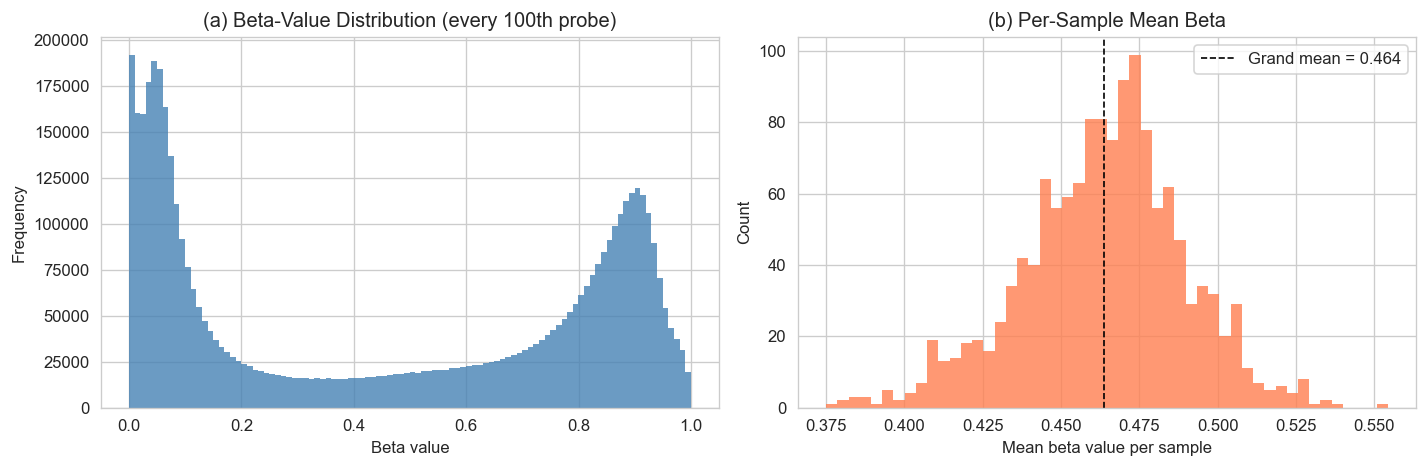

In [8]:

# Cell 15: Missingness analysis


total_values = beta_df.size
total_missing = beta_df.isna().sum().sum()
pct_missing = 100 * total_missing / total_values

print(f"Matrix: {beta_df.shape[0]:,} probes × {beta_df.shape[1]:,} samples")
print(f"Total values: {total_values:,}")
print(f"Missing values: {total_missing:,} ({pct_missing:.4f}%)")

if total_missing == 0:
    print("\n No missing values detected — KNN imputation is NOT required.")
    print("   This is expected as GSE130051 provides fully processed beta values [1].")
    
    # Still produce a summary figure for completeness
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # (a) Distribution of beta values (sample of probes for speed)
    sample_vals = beta_df.iloc[::100, :].values.flatten()
    sample_vals = sample_vals[~np.isnan(sample_vals)]
    axes[0].hist(sample_vals, bins=100, color='steelblue', edgecolor='none', alpha=0.8)
    axes[0].set_xlabel('Beta value')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('(a) Beta-Value Distribution (every 100th probe)')
    
    # (b) Per-sample mean beta
    sample_means = beta_df.mean(axis=0)
    axes[1].hist(sample_means, bins=50, color='coral', edgecolor='none', alpha=0.8)
    axes[1].set_xlabel('Mean beta value per sample')
    axes[1].set_ylabel('Count')
    axes[1].set_title('(b) Per-Sample Mean Beta')
    axes[1].axvline(sample_means.mean(), color='black', ls='--', lw=1,
                    label=f'Grand mean = {sample_means.mean():.3f}')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'missingness_and_distribution.png'), dpi=150)
    plt.show()
    
else:
    print(f"\n Missing values found. Visualising patterns...")
    
    # Per-probe missingness
    probe_miss = beta_df.isna().mean(axis=1)
    # Per-sample missingness
    sample_miss = beta_df.isna().mean(axis=0)
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    
    axes[0].hist(probe_miss[probe_miss > 0], bins=50, color='steelblue')
    axes[0].set_xlabel('Fraction missing per probe')
    axes[0].set_ylabel('Count')
    axes[0].set_title('(a) Per-Probe Missingness')
    
    axes[1].hist(sample_miss[sample_miss > 0], bins=50, color='coral')
    axes[1].set_xlabel('Fraction missing per sample')
    axes[1].set_ylabel('Count')
    axes[1].set_title('(b) Per-Sample Missingness')
    
    # Pie chart
    axes[2].pie([total_missing, total_values - total_missing],
                labels=['Missing', 'Present'], autopct='%1.2f%%',
                colors=['#ff6b6b', '#51cf66'])
    axes[2].set_title('(c) Overall Missingness')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'missingness_analysis.png'), dpi=150)
    plt.show()
    
    # KNN imputation
    print("\nApplying KNN imputation (k=5)...")
    from sklearn.impute import KNNImputer
    imputer = KNNImputer(n_neighbors=5)
    beta_imputed = imputer.fit_transform(beta_df.T.values)  # samples × probes
    beta_df = pd.DataFrame(beta_imputed.T, index=beta_df.index, 
                           columns=beta_df.columns).astype(np.float32)
    print(f" Imputation complete. Remaining NaN: {beta_df.isna().sum().sum()}")

### 6. Cross, Platform Probe Intersection

The GSE130051 dataset contains samples from two Illumina platforms: HumanMethylation450 (450K, n=1, 271) and MethylationEPIC (EPIC, n=99). In order to make the samples comparable, we only keep CpG probes that are on both platforms. The intersection usually returns ~450, 000 common probes [1], but after our filtering pipeline, we only keep those that have passed quality control.

Because the beta, value matrix was pre, harmonised by Sharma et al. [1] using only those probes that are common to both platforms, the entire 363, 205 probes left are at that point cross, platform compatible.

In [9]:

# Cell 17: Verify cross-platform compatibility

# The Sharma et al. dataset was constructed using only probes common
# to both 450K and EPIC platforms. Verify this is the case.

platform_samples = {
    '450K': meta_df[meta_df['platform'] == '450K'].index.tolist(),
    'EPIC': meta_df[meta_df['platform'] == 'EPIC'].index.tolist()
}

print("Cross-platform verification:")
for plat, samples in platform_samples.items():
    plat_cols = [s for s in samples if s in beta_df.columns]
    if plat_cols:
        non_null = beta_df[plat_cols].notna().mean(axis=1)
        probes_with_data = (non_null > 0.5).sum()
        print(f"  {plat}: {len(plat_cols)} samples, {probes_with_data:,} probes with >50% data")

print(f"\n All {beta_df.shape[0]:,} probes are cross-platform compatible (pre-harmonised in [1]).")
print(f"   No additional intersection step required.")

Cross-platform verification:
  450K: 1271 samples, 363,205 probes with >50% data
  EPIC: 99 samples, 363,205 probes with >50% data

 All 363,205 probes are cross-platform compatible (pre-harmonised in [1]).
   No additional intersection step required.


## 7. Variance-Based Probe Selection

Among the filtered probes, we take the top 10, 000 most variable CpG based on the standard deviation across all the 1, 370 samples. High, variance probes essentially have the most significant differentiating signal for separating the 8 molecular subtypes [1].

> **Methodological Note:**
> Although this pipeline is adapted from Abid and Rafiee [4], I have streamlined the feature selection step. The original research used a correlation, based filter ($|r| > 0.4$) along with the variance. For this assignment, we use a variance, based selection (Top 10, 000) method in order to cut down the dimensionality while keeping the most informative probes for NMF, thus being in line with the method in Sharma et al. [1].

## 8. Feature Scaling

Beta values are naturally constrained to the interval [0, 1] and thus they are on the same scale. Since the biological range is crucial, standard normalisation (z, score) would be inappropriate and minmax scaling is unnecessary because values are already in [0, 1]. Consequently, no further feature scaling is done, which agrees with the conventional practice of methylation analysis.

In the case of NMF, the input matrix has to be non, negative, which is true for beta values by definition.

Computing probe-wise standard deviation across 1,370 samples...

Std deviation statistics:
  Max:    0.4102
  Min:    0.002358
  Median: 0.0773
  Mean:   0.0974

 Selected top 10,000 most variable probes
   Shape: (10000, 1370)
   Std range: [0.2601, 0.4102]
   Memory: 55.5 MB


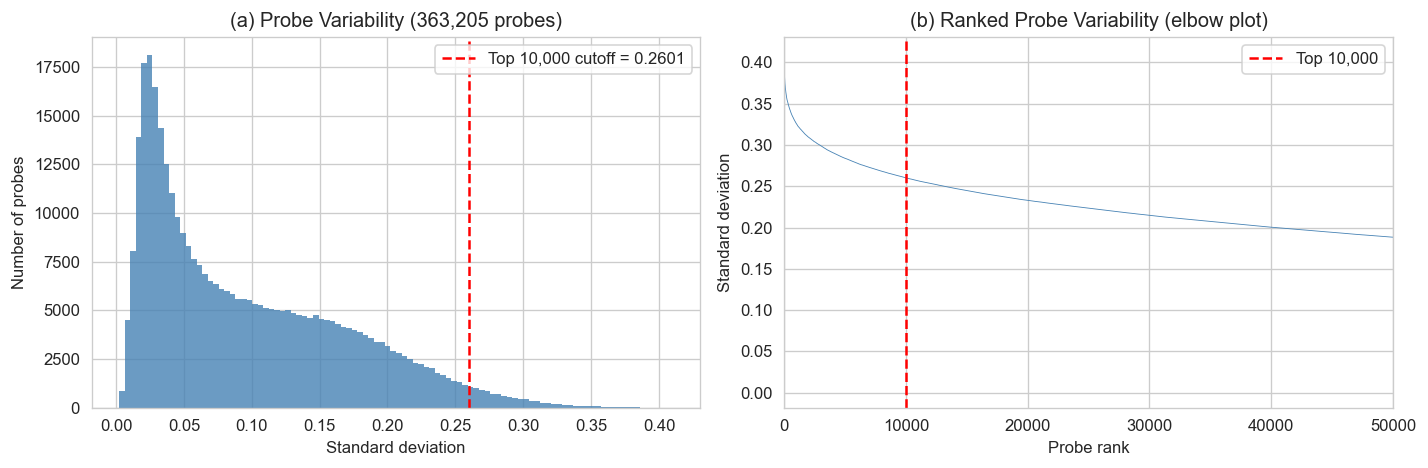

In [10]:

# Cell 19: Variance-based probe selection (top 10,000)


TOP_N = 10_000

print(f"Computing probe-wise standard deviation across {beta_df.shape[1]:,} samples...")
probe_std = beta_df.std(axis=1).sort_values(ascending=False)

print(f"\nStd deviation statistics:")
print(f"  Max:    {probe_std.iloc[0]:.4f}")
print(f"  Min:    {probe_std.iloc[-1]:.6f}")
print(f"  Median: {probe_std.median():.4f}")
print(f"  Mean:   {probe_std.mean():.4f}")

# Select top N
top_probes = probe_std.head(TOP_N).index
beta_top = beta_df.loc[top_probes]

print(f"\n Selected top {TOP_N:,} most variable probes")
print(f"   Shape: {beta_top.shape}")
print(f"   Std range: [{probe_std.iloc[TOP_N-1]:.4f}, {probe_std.iloc[0]:.4f}]")
print(f"   Memory: {beta_top.memory_usage(deep=True).sum()/1e6:.1f} MB")

# Visualise variance distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# (a) Std distribution with cutoff
axes[0].hist(probe_std.values, bins=100, color='steelblue', edgecolor='none', alpha=0.8)
cutoff = probe_std.iloc[TOP_N-1]
axes[0].axvline(cutoff, color='red', ls='--', lw=1.5,
                label=f'Top {TOP_N:,} cutoff = {cutoff:.4f}')
axes[0].set_xlabel('Standard deviation')
axes[0].set_ylabel('Number of probes')
axes[0].set_title(f'(a) Probe Variability ({beta_df.shape[0]:,} probes)')
axes[0].legend()

# (b) Ranked variance plot
axes[1].plot(range(1, len(probe_std)+1), probe_std.values, color='steelblue', lw=0.5)
axes[1].axvline(TOP_N, color='red', ls='--', lw=1.5, label=f'Top {TOP_N:,}')
axes[1].set_xlabel('Probe rank')
axes[1].set_ylabel('Standard deviation')
axes[1].set_title('(b) Ranked Probe Variability (elbow plot)')
axes[1].set_xlim(0, 50000)
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'variance_selection.png'), dpi=150)
plt.show()

## 9. Dimensionality Reduction

We use three mutually reinforcing dimensionality reduction methods on the top 10, 000 most variable probes to understand the sample, level structure visually before NMF clustering:

1.**PCA** a linear projection that keeps the global variance [8]

2.**t,SNE** a non, linear embedding that preserves the local neighbourhood structure (perplexity = 30) [7]

3.**UMAP** a non, linear embedding that tries to preserve both local and global topology [6]

Running PCA...
  PC1: 31.5%, PC2: 9.1%
  Cumulative (10 PCs): 57.1%
Running t-SNE (perplexity=30)...
Running UMAP...


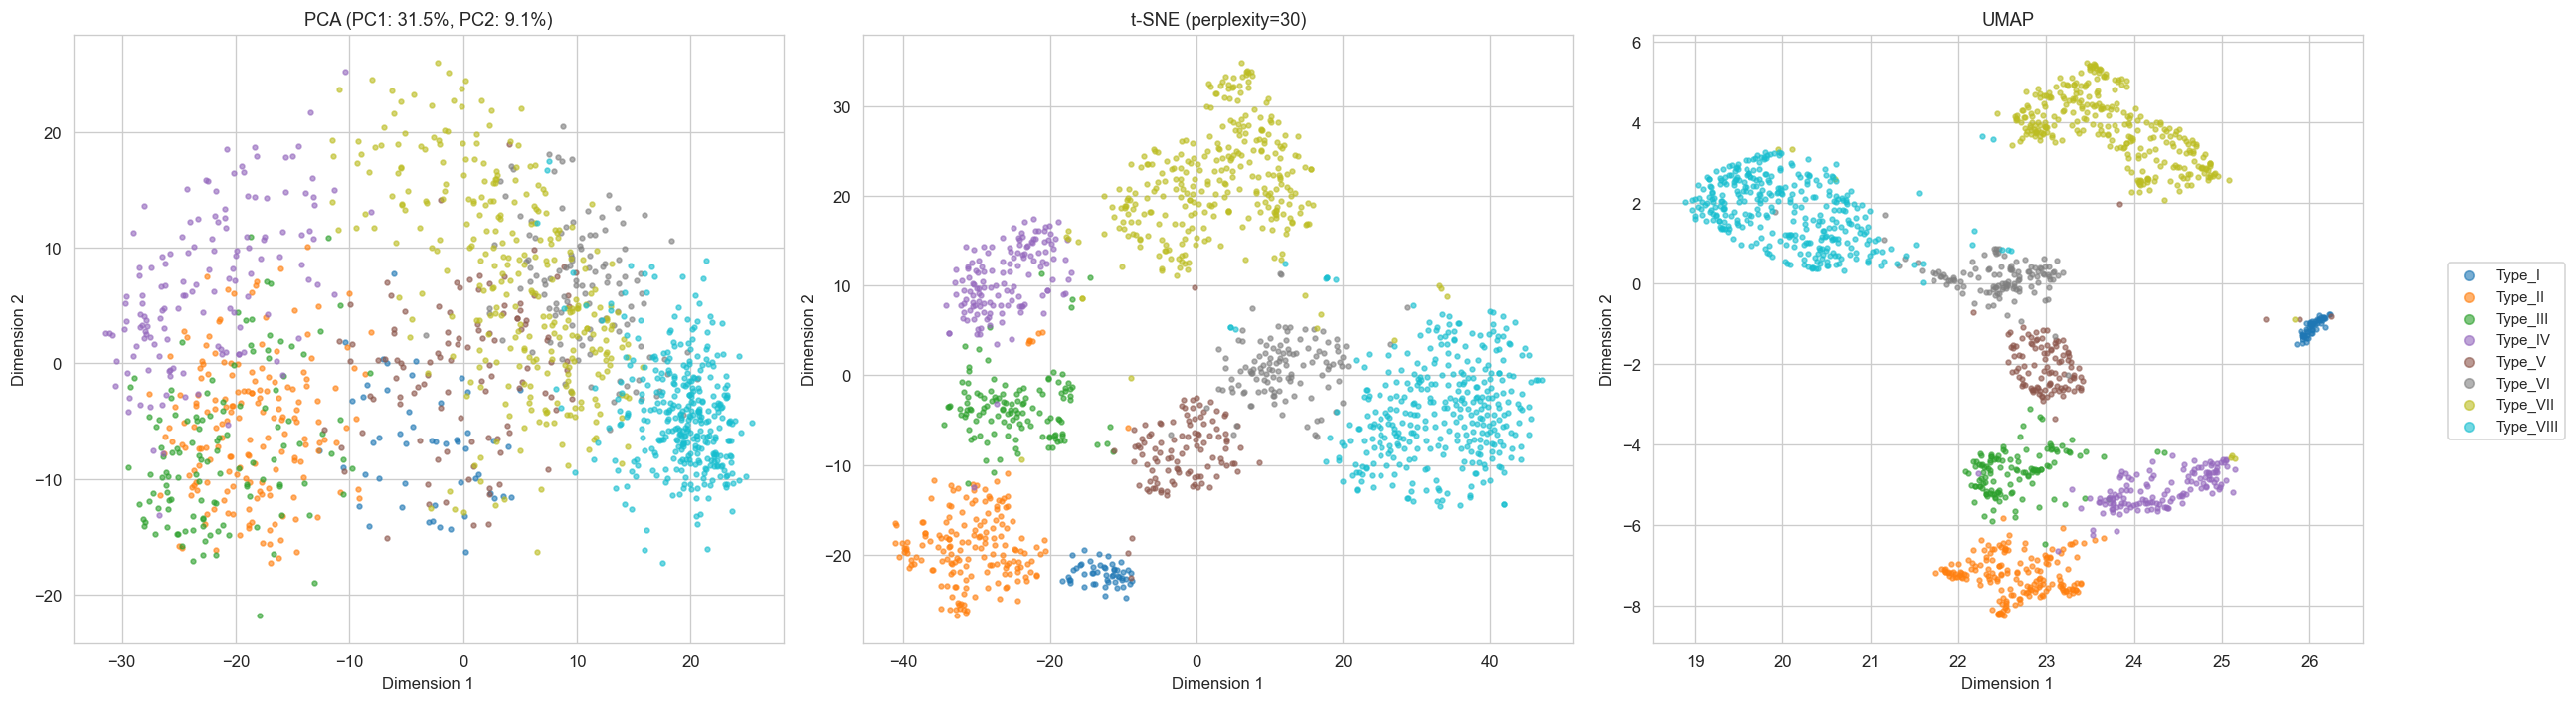

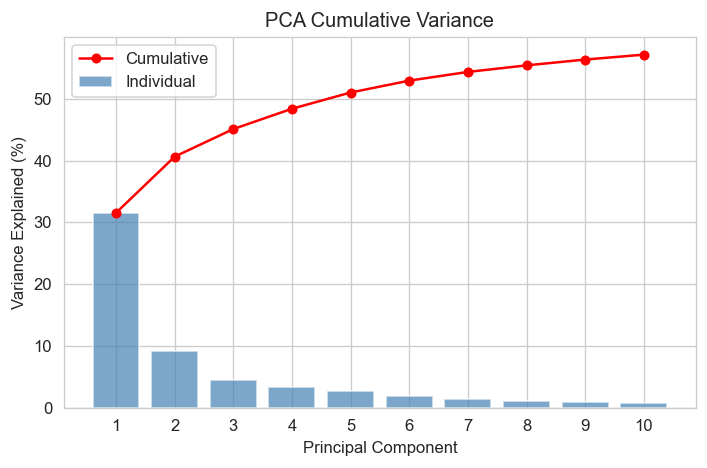


 Dimensionality reduction complete.


In [11]:

# Cell 22: PCA, t-SNE, and UMAP visualisation

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# Prepare data: samples × probes (transpose of beta_top)
X = beta_top.T.values  # (1370, 10000)
labels = meta_df.loc[beta_top.columns, 'subtype_label'].values
subgroups = meta_df.loc[beta_top.columns, 'subgroup'].values

# Colour map for 8 subtypes
subtype_order = ['Type_I', 'Type_II', 'Type_III', 'Type_IV',
                 'Type_V', 'Type_VI', 'Type_VII', 'Type_VIII']
cmap = plt.cm.get_cmap('tab10', 8)
color_map = {st: cmap(i) for i, st in enumerate(subtype_order)}
colors = [color_map[l] for l in labels]

# --- PCA ---
print("Running PCA...")
pca = PCA(n_components=10, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X)
var_explained = pca.explained_variance_ratio_

print(f"  PC1: {var_explained[0]*100:.1f}%, PC2: {var_explained[1]*100:.1f}%")
print(f"  Cumulative (10 PCs): {sum(var_explained)*100:.1f}%")

# --- t-SNE ---
print("Running t-SNE (perplexity=30)...")
tsne = TSNE(n_components=2, perplexity=30, random_state=RANDOM_STATE, 
            max_iter=1000, init='pca', learning_rate='auto')

X_tsne = tsne.fit_transform(X)

# --- UMAP ---
print("Running UMAP...")
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, 
                     random_state=RANDOM_STATE)
X_umap = reducer.fit_transform(X)

# --- Plot all three ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, data, title in zip(axes, 
                            [X_pca[:, :2], X_tsne, X_umap],
                            [f'PCA (PC1: {var_explained[0]*100:.1f}%, PC2: {var_explained[1]*100:.1f}%)',
                             't-SNE (perplexity=30)',
                             'UMAP']):
    for st in subtype_order:
        mask = labels == st
        ax.scatter(data[mask, 0], data[mask, 1], 
                   c=[color_map[st]], label=st, s=8, alpha=0.6)
    ax.set_title(title, fontsize=11)
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')

# Single legend
handles, lbls = axes[0].get_legend_handles_labels()
fig.legend(handles, lbls, loc='center right', fontsize=9, 
           markerscale=2, bbox_to_anchor=(1.08, 0.5))

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'dimensionality_reduction.png'), 
            dpi=150, bbox_inches='tight')
plt.show()

# --- PCA cumulative variance plot ---
fig, ax = plt.subplots(figsize=(6, 4))
cumvar = np.cumsum(var_explained)
ax.bar(range(1, 11), var_explained * 100, color='steelblue', alpha=0.7, label='Individual')
ax.plot(range(1, 11), cumvar * 100, 'ro-', markersize=5, label='Cumulative')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Variance Explained (%)')
ax.set_title('PCA Cumulative Variance')
ax.legend()
ax.set_xticks(range(1, 11))
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'pca_variance.png'), dpi=150)
plt.show()

print("\n Dimensionality reduction complete.")

## 10. Non-Negative Matrix Factorisation (NMF)

### 10.1 Optimal Rank Selection

NMF decomposes the beta-value matrix **V** (probes × samples) into **W** (probes × k) and **H** (k × samples), where *k* is the factorisation rank. We test ranks $k = 2-15$ and select the optimal *k* using the **cophenetic correlation coefficient** [5], which measures the stability of cluster assignments across multiple runs.



NMF rank selection: testing k=2–15 with 10 runs each
Matrix: 10,000 probes × 1,370 samples

  k= 2: cophenetic = 1.0000
  k= 3: cophenetic = 0.9999
  k= 4: cophenetic = 1.0000
  k= 5: cophenetic = 1.0000
  k= 6: cophenetic = 1.0000
  k= 7: cophenetic = 1.0000
  k= 8: cophenetic = 1.0000
  k= 9: cophenetic = 0.9953
  k=10: cophenetic = 0.9935
  k=11: cophenetic = 0.9718
  k=12: cophenetic = 0.9976
  k=13: cophenetic = 0.9974
  k=14: cophenetic = 0.9703
  k=15: cophenetic = 0.9936


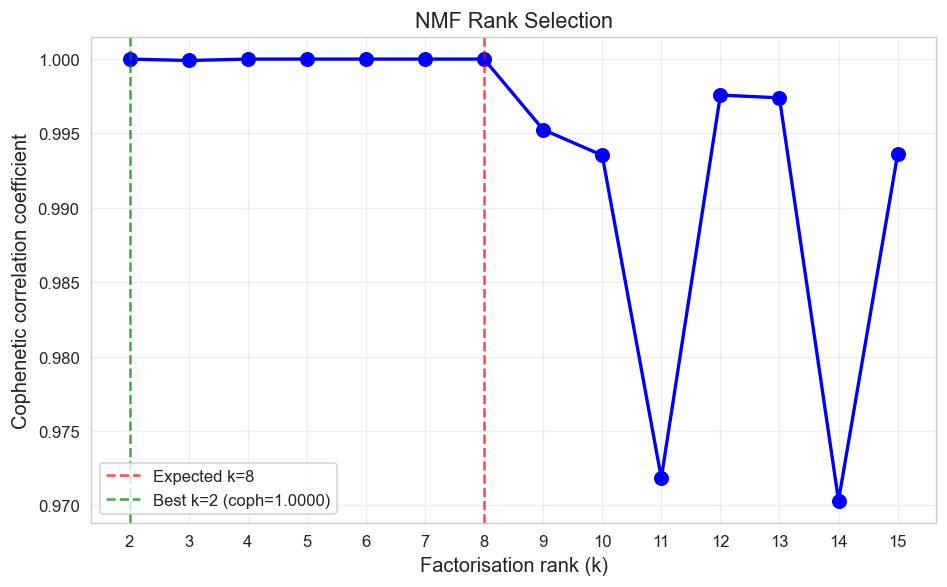


 Optimal rank: k=2 (cophenetic = 1.0000)
   Expected k=8 cophenetic = 1.0000


In [12]:

# Cell 24: NMF optimal rank selection via cophenetic correlation

from sklearn.decomposition import NMF
from scipy.cluster.hierarchy import linkage, cophenet
from scipy.spatial.distance import pdist, squareform

# Use the top 10,000 probes matrix
V = beta_top.values  # (10000, 1370) — probes × samples
# NMF requires non-negative input — clip any tiny negatives from float precision
V = np.clip(V, 0, None)

ranks = range(2, 16)
n_runs = 10  # runs per rank for stability
cophenetic_scores = []

print(f"NMF rank selection: testing k={min(ranks)}–{max(ranks)} with {n_runs} runs each")
print(f"Matrix: {V.shape[0]:,} probes × {V.shape[1]:,} samples\n")

for k in ranks:
    H_runs = []
    
    for run in range(n_runs):
        model = NMF(n_components=k, init='nndsvda', max_iter=300,
                    random_state=RANDOM_STATE + run, l1_ratio=0.0)
        W = model.fit_transform(V)
        H = model.components_  # (k, samples)
        
        # Assign each sample to its dominant metagene
        assignments = np.argmax(H, axis=0)
        H_runs.append(assignments)
    
    # Build connectivity matrices and compute cophenetic correlation
    n_samples = V.shape[1]
    consensus = np.zeros((n_samples, n_samples))
    
    for assignments in H_runs:
        for i in range(n_samples):
            for j in range(i+1, n_samples):
                if assignments[i] == assignments[j]:
                    consensus[i, j] += 1
                    consensus[j, i] += 1
    
    consensus /= n_runs
    np.fill_diagonal(consensus, 1.0)
    
    # Cophenetic correlation
    dist_matrix = 1 - consensus
    np.fill_diagonal(dist_matrix, 0)
    linkage_matrix = linkage(squareform(dist_matrix), method='average')
    coph_corr, _ = cophenet(linkage_matrix, squareform(dist_matrix))
    
    cophenetic_scores.append(coph_corr)
    print(f"  k={k:2d}: cophenetic = {coph_corr:.4f}")

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(list(ranks), cophenetic_scores, 'bo-', markersize=8, linewidth=2)
ax.axvline(8, color='red', ls='--', lw=1.5, alpha=0.7, label='Expected k=8')

best_k = list(ranks)[np.argmax(cophenetic_scores)]
ax.axvline(best_k, color='green', ls='--', lw=1.5, alpha=0.7, 
           label=f'Best k={best_k} (coph={max(cophenetic_scores):.4f})')

ax.set_xlabel('Factorisation rank (k)', fontsize=12)
ax.set_ylabel('Cophenetic correlation coefficient', fontsize=12)
ax.set_title('NMF Rank Selection', fontsize=13)
ax.set_xticks(list(ranks))
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'nmf_rank_selection.png'), dpi=150)
plt.show()

print(f"\n Optimal rank: k={best_k} (cophenetic = {max(cophenetic_scores):.4f})")
print(f"   Expected k=8 cophenetic = {cophenetic_scores[8-min(ranks)]:.4f}")

> **Interpretation of Rank Stability:**
> From $k=2$ to $k=8$, the cophenetic correlation coefficient stays around 1. 0000. This 'saturation' means that the data is very stably clustered at different resolutions. We pick $k=8$ because it is the highest rank perfectly stable after which the stability at $k=9$ is slightly worse and it moreover follows the agreement of 8 molecular subtypes by Sharma et al. which is the biological standard.[1].

### 10.2 NMF at k=8

We fit the final NMF model at **k=8** — the biologically expected number of Group 3/4 subtypes [1]. Each sample is assigned to the metagene (basis component) with the highest coefficient in the **H** matrix.

Running final NMF with k=8, 50 runs...

Best reconstruction error: 737.03

NMF cluster sizes:
  Cluster 0: 632 samples
  Cluster 1: 213 samples
  Cluster 2: 60 samples
  Cluster 3: 60 samples
  Cluster 4: 66 samples
  Cluster 5: 271 samples
  Cluster 6: 23 samples
  Cluster 7: 45 samples


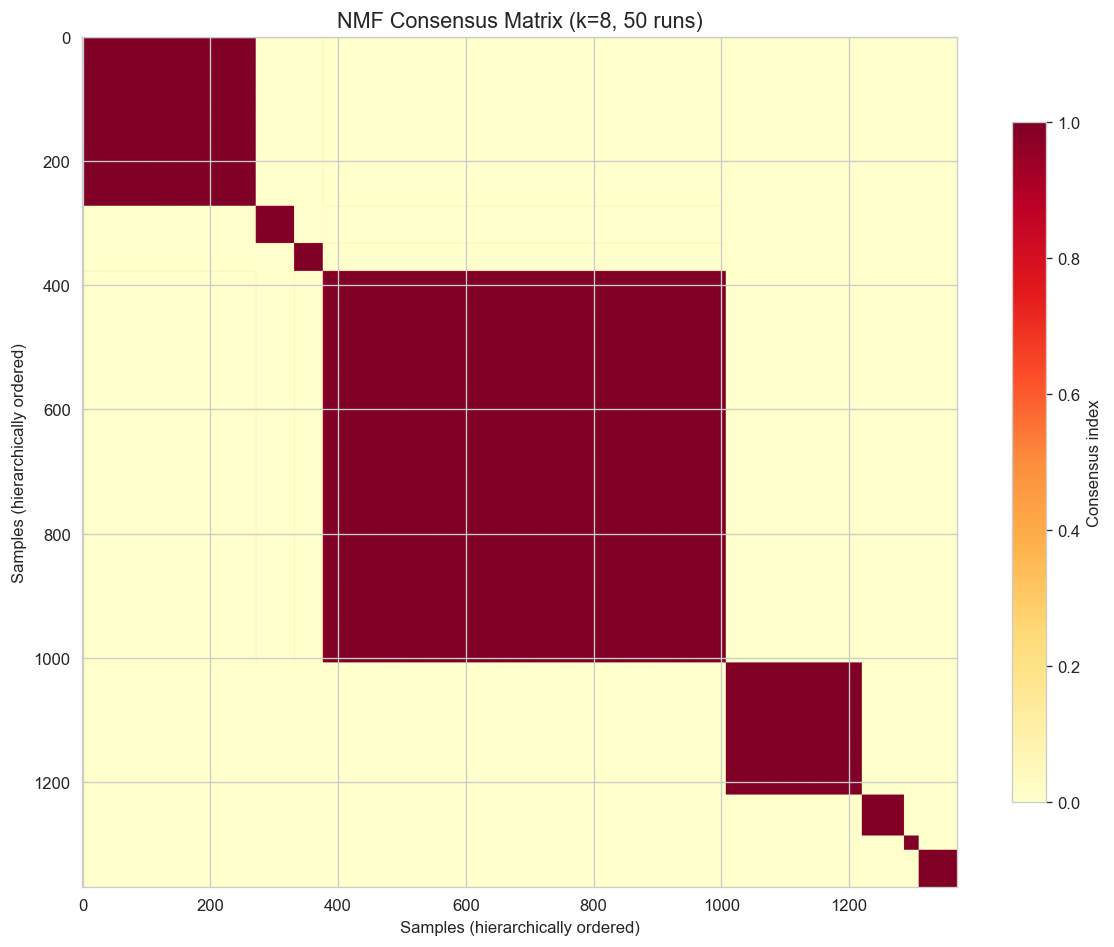

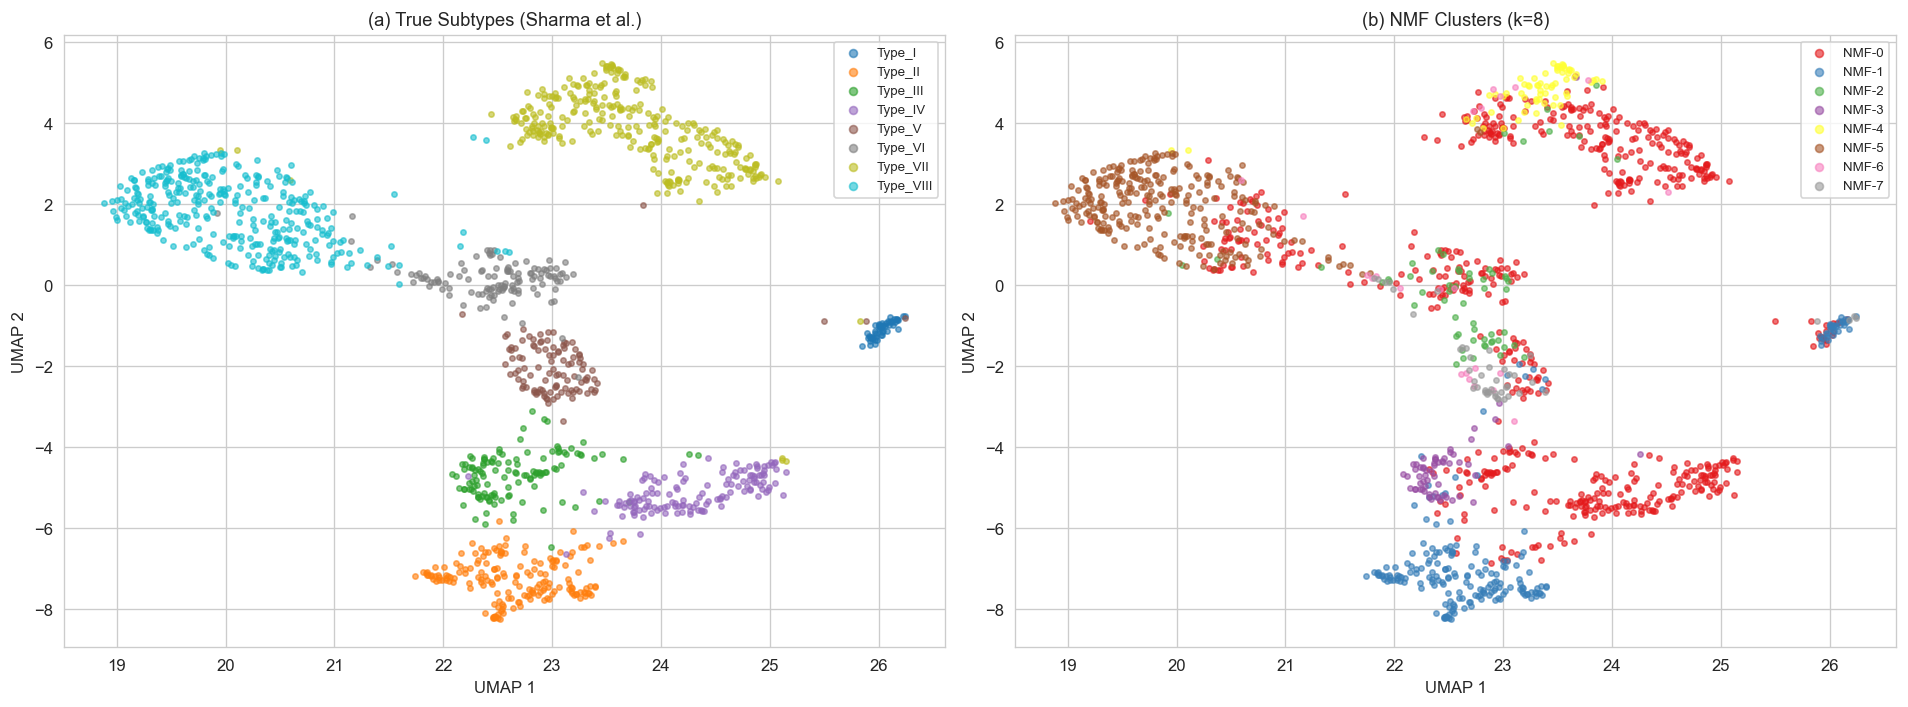

In [13]:

# Cell 26: Final NMF at k=8, consensus clustering, and visualisation


K_FINAL = 8
N_RUNS = 50  # more runs for final consensus

print(f"Running final NMF with k={K_FINAL}, {N_RUNS} runs...\n")

# --- Multiple runs for consensus ---
n_samples = V.shape[1]
consensus = np.zeros((n_samples, n_samples))
best_model = None
best_err = np.inf

for run in range(N_RUNS):
    model = NMF(n_components=K_FINAL, init='nndsvda', max_iter=500,
                random_state=RANDOM_STATE + run, l1_ratio=0.0)
    W = model.fit_transform(V)
    H = model.components_
    
    err = model.reconstruction_err_
    if err < best_err:
        best_err = err
        best_model = model
        best_W = W
        best_H = H
    
    assignments = np.argmax(H, axis=0)
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            if assignments[i] == assignments[j]:
                consensus[i, j] += 1
                consensus[j, i] += 1

consensus /= N_RUNS
np.fill_diagonal(consensus, 1.0)

# Final assignments from best model
nmf_clusters = np.argmax(best_H, axis=0)
sample_ids = beta_top.columns.tolist()

print(f"Best reconstruction error: {best_err:.2f}")
print(f"\nNMF cluster sizes:")
for c in range(K_FINAL):
    count = (nmf_clusters == c).sum()
    print(f"  Cluster {c}: {count} samples")

# Add NMF cluster to metadata
meta_df.loc[sample_ids, 'nmf_cluster'] = nmf_clusters
meta_df['nmf_cluster'] = meta_df['nmf_cluster'].astype('Int64')

# --- Consensus heatmap ---
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform

dist = 1 - consensus
np.fill_diagonal(dist, 0)
Z = linkage(squareform(dist), method='average')
order = leaves_list(Z)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(consensus[np.ix_(order, order)], cmap='YlOrRd', 
               vmin=0, vmax=1, aspect='auto')
ax.set_title(f'NMF Consensus Matrix (k={K_FINAL}, {N_RUNS} runs)', fontsize=13)
ax.set_xlabel('Samples (hierarchically ordered)')
ax.set_ylabel('Samples (hierarchically ordered)')
plt.colorbar(im, ax=ax, label='Consensus index', shrink=0.8)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'nmf_consensus_heatmap.png'), dpi=150)
plt.show()

# --- NMF clusters on UMAP ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# (a) True subtypes on UMAP
for st in subtype_order:
    mask = labels == st
    axes[0].scatter(X_umap[mask, 0], X_umap[mask, 1], 
                    c=[color_map[st]], label=st, s=10, alpha=0.6)
axes[0].set_title('(a) True Subtypes (Sharma et al.)', fontsize=11)
axes[0].legend(fontsize=8, markerscale=1.5)
axes[0].set_xlabel('UMAP 1')
axes[0].set_ylabel('UMAP 2')

# (b) NMF clusters on UMAP
cmap_nmf = plt.cm.get_cmap('Set1', K_FINAL)
for c in range(K_FINAL):
    mask = nmf_clusters == c
    axes[1].scatter(X_umap[mask, 0], X_umap[mask, 1],
                    c=[cmap_nmf(c)], label=f'NMF-{c}', s=10, alpha=0.6)
axes[1].set_title(f'(b) NMF Clusters (k={K_FINAL})', fontsize=11)
axes[1].legend(fontsize=8, markerscale=1.5)
axes[1].set_xlabel('UMAP 1')
axes[1].set_ylabel('UMAP 2')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'nmf_vs_true_umap.png'), dpi=150)

## NMF Metagene Activation Heatmap

The rows of the matrix H(k samples) represent how strongly each metagene is activated in each sample. If you look at it like heatmap, with the samples classified according to their consensus subtype, the method of NMF can be estimated by checking if the identified biologically meaningful patterns are shown. Each row corresponds to one of the 8 metagenes, whereas each column corresponds to a sample. The columns are sorted by subtype label to make the block, diagonal activation patterns visible.

These patterns show that certain metagenes are associated with certain molecular subtypes [1].

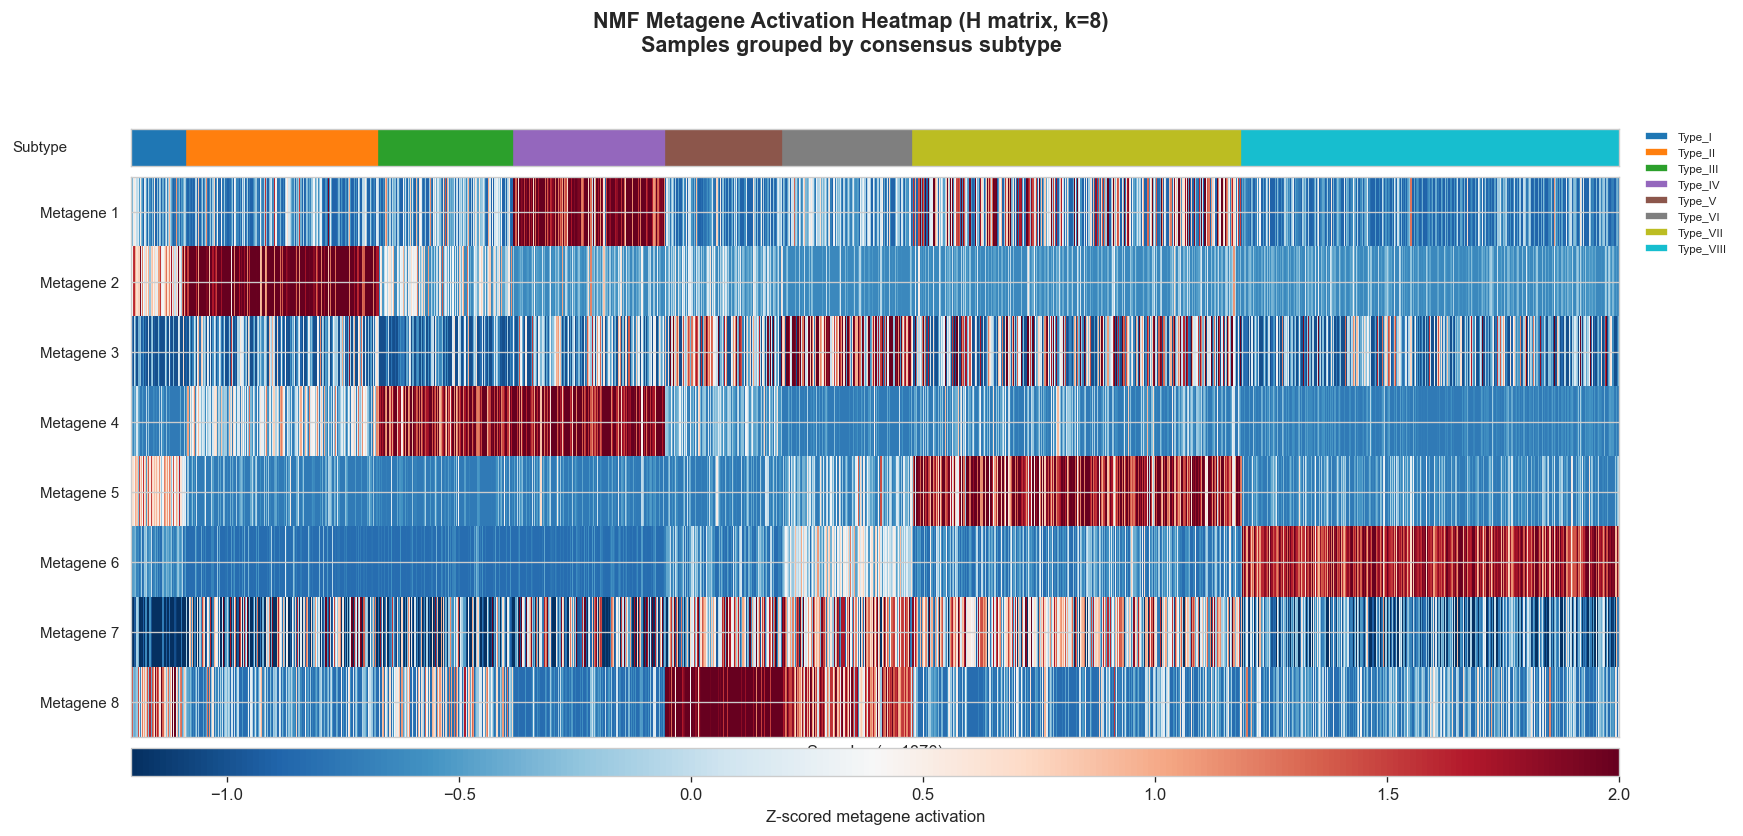


Cross-tabulation: True Subtype vs Dominant Metagene

              MG-1  MG-2  MG-3  MG-4  MG-5  MG-6  MG-7  MG-8
True Subtype                                                
Type_I          17    32     0     0     0     0     0     2
Type_II         14   163     0     0     0     0     0     0
Type_III        55    12     0    57     0     0     0     0
Type_IV        139     0     0     1     0     0     0     0
Type_V          36     6    20     1     0     0     8    37
Type_VI         71     0    31     0     0     5     7     6
Type_VII       219     0     7     1    66     2     8     0
Type_VIII       81     0     2     0     0   264     0     0


In [18]:
# Cell 27: NMF Metagene Activation Heatmap (H matrix)

from matplotlib.patches import Patch

# best_H shape: (8, 1370) — metagenes × samples
H_df = pd.DataFrame(
    best_H,
    index=[f'Metagene {i+1}' for i in range(K_FINAL)],
    columns=beta_top.columns
)

# Sort samples by their true subtype label
sorted_samples = meta_df.loc[beta_top.columns].sort_values('subtype_label').index
H_sorted = H_df[sorted_samples]

# Z-score normalisation per metagene for better visual contrast (numpy)
H_norm = H_sorted.values
H_norm = (H_norm - H_norm.mean(axis=1, keepdims=True)) / (H_norm.std(axis=1, keepdims=True) + 1e-10)
H_norm = np.clip(H_norm, -2, 2)

# --- Plot ---
fig, (ax_top, ax_main, ax_cbar) = plt.subplots(
    3, 1, figsize=(16, 7),
    gridspec_kw={'height_ratios': [0.4, 6, 0.3], 'hspace': 0.05}
)

# (a) Top: subtype colour annotation bar
for i, sample in enumerate(sorted_samples):
    st = meta_df.loc[sample, 'subtype_label']
    ax_top.axvspan(i - 0.5, i + 0.5, color=color_map[st])
ax_top.set_xlim(-0.5, len(sorted_samples) - 0.5)
ax_top.set_xticks([])
ax_top.set_yticks([])
ax_top.set_ylabel('Subtype', fontsize=9, rotation=0, labelpad=55, va='center')

# Legend
legend_patches = [Patch(facecolor=color_map[s], label=s) for s in subtype_order]
ax_top.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1.01, 1.2),
              fontsize=7, frameon=False, ncol=1)

# (b) Main: heatmap of H matrix
im = ax_main.imshow(H_norm, aspect='auto', cmap='RdBu_r',
                     interpolation='none')
ax_main.set_yticks(range(K_FINAL))
ax_main.set_yticklabels([f'Metagene {i+1}' for i in range(K_FINAL)], fontsize=9)
ax_main.set_xticks([])
ax_main.set_xlabel(f'Samples (n={len(sorted_samples)})', fontsize=10)

# (c) Bottom: colour bar
plt.colorbar(im, cax=ax_cbar, orientation='horizontal', label='Z-scored metagene activation')

plt.suptitle('NMF Metagene Activation Heatmap (H matrix, k=8)\nSamples grouped by consensus subtype',
             fontsize=13, fontweight='bold', y=1.02)

plt.savefig(os.path.join(OUTPUT_DIR, 'nmf_metagene_heatmap.png'), dpi=200, bbox_inches='tight')
plt.show()

# --- Cross-tabulation: dominant metagene vs true subtype ---
dominant_metagene = np.argmax(best_H, axis=0)
ct = pd.crosstab(
    meta_df.loc[beta_top.columns, 'subtype_label'],
    dominant_metagene,
    rownames=['True Subtype'],
    colnames=['Dominant Metagene']
)
ct.columns = [f'MG-{i+1}' for i in ct.columns]
print("\nCross-tabulation: True Subtype vs Dominant Metagene\n")
print(ct.to_string())

## Interpretation of NMF Metagene Heatmap:
The heatmap displays the matrix H (8 metagenes 1, 370 samples) with the sample columns being ordered by the consensus subtype and the rows showing metagene activation intensities (z, scored). A few distinct block, diagonal patterns can be seen, thus showing that different metagenes describe the subtype, specific methylation signatures:

Metagene 2 is highly activated, but only for Type II samples (163/177 assigned), thus it is a very different epigenetic profile that this subtype has.

Most of the Metagene 6 activation area corresponds to Type VIII (264/347), the largest subtype in the dataset, with a very evident activation block.

Metagene 1 identifies the largest proportion of Type IV (139/140) completely, hence a distinctive methylation pattern of the separated group from the rest of the subtypes can be inferred.

Metagene 4 in part regains Type III (57/124) along with Metagene 1, which may be indicative of some overlap of Type III and Type IV within Group 3 at the level of the methylation basis.

Attributes of some subtypes especially Type V, Type VI, and Type VII are spread over several metagenes instead of relating to just one of the components distinctly. This is quite naturally expected biologically: Sharma et al. [1] have mentioned that some subtypes of Group 4 possess some commingling epigenetic traits, which is why they are intrinsically the most difficult to separate by unsupervised approaches only. The cross, tabulation illustrates that Metagene 1 takes in the samples coming from the various subtypes and thus operates as a 'broad Group 3/4' component instead of being subtype, specific one.

Although there are these overlaps, the NMF decomposition manages to shrink the feature space from 10, 000 CpG probes to 8 biologically interpretable metagenes and still keeps enough subtype information for downstream supervised classification in Part 2. The roughly correct separation at the unsupervised level is exactly why a supervised classifier is needed the metagene features offer a compact, informative lay, out that a trained model can utilize to solve the remaining dilemmas.

## 11. Export ML-Ready Dataset

The final ML, ready dataset is exported as a single CSV file for downstream supervised classification. Each row corresponds to a sample, with columns holding the 10, 000 CpG probe beta values and related metadata labels. also Saved NMF-reduced dataset (8 features).

In [15]:

# Cell 28: Export ML-ready dataset


# Transpose: samples × probes
export_df = beta_top.T.copy()
export_df.index.name = 'sample_id'

# Add metadata columns
export_df.insert(0, 'subtype', meta_df.loc[export_df.index, 'subtype_label'].values)
export_df.insert(1, 'subgroup', meta_df.loc[export_df.index, 'subgroup'].values)
export_df.insert(2, 'platform', meta_df.loc[export_df.index, 'platform'].values)
export_df.insert(3, 'nmf_cluster', meta_df.loc[export_df.index, 'nmf_cluster'].values)

print(f"Export dataset shape: {export_df.shape}")
print(f"  Samples: {export_df.shape[0]}")
print(f"  Features: {export_df.shape[1] - 4} CpG probes + 4 metadata columns")
print(f"\nSubtype distribution:")
print(export_df['subtype'].value_counts().sort_index().to_string())

# Save
output_file = os.path.join(OUTPUT_DIR, 'GSE130051_ML_ready.csv.gz')
export_df.to_csv(output_file, compression='gzip')
file_size = os.path.getsize(output_file) / 1e6
print(f"\n Saved: {output_file}")
print(f"   File size: {file_size:.1f} MB")

# Also save probe list and metadata separately for reference
probe_list = pd.DataFrame({'probe_id': beta_top.index, 
                           'std': probe_std.loc[beta_top.index].values})
probe_list.to_csv(os.path.join(OUTPUT_DIR, 'selected_probes_10k.csv'), index=False)

meta_export = meta_df.loc[sample_ids, ['subtype_label', 'subgroup', 'platform', 'nmf_cluster']]
meta_export.to_csv(os.path.join(OUTPUT_DIR, 'sample_metadata.csv'))

print(f"   Also saved: selected_probes_10k.csv, sample_metadata.csv")



# Create a "Metagene" dataset (Samples x 8 Metagenes)
# best_H is shape (8, 1370), so we transpose it to (1370, 8)
metagene_features = pd.DataFrame(
    best_H.T, 
    index=sample_ids, 
    columns=[f'Metagene_{i+1}' for i in range(K_FINAL)]
)

# Merge with Class Labels
ml_ready_metagenes = pd.concat([
    meta_df.loc[sample_ids, ['subtype_label', 'subgroup', 'platform']], 
    metagene_features
], axis=1)

# Save
meta_out_file = os.path.join(OUTPUT_DIR, '40498551_Ajaysai_Kummara_ECS8055_ICW_200226.csv')
ml_ready_metagenes.to_csv(meta_out_file)

print(f": Saved NMF-reduced dataset (8 features): {meta_out_file}")

Export dataset shape: (1370, 10004)
  Samples: 1370
  Features: 10000 CpG probes + 4 metadata columns

Subtype distribution:
subtype
Type_I        51
Type_II      177
Type_III     124
Type_IV      140
Type_V       108
Type_VI      120
Type_VII     303
Type_VIII    347

 Saved: output/GSE130051_ML_ready.csv.gz
   File size: 60.6 MB
   Also saved: selected_probes_10k.csv, sample_metadata.csv
: Saved NMF-reduced dataset (8 features): output/40498551_Ajaysai_Kummara_ECS8055_ICW_200226.csv


## 12. Summary

This notebook prepared an ML-ready dataset from the GSE130051 medulloblastoma DNA methylation compendium [1]:

| Stage | Description | Result |
|-------|-------------|--------|
| Data loading | Beta-value matrix from GEO | 453,152 probes × 1,501 samples(After transposing). |
| Sample selection | Exclude MBNOS; retain Group 3/4 Types I–VIII | 1,370 samples |
| Probe filtering | Remove non-CpG, sex chr, cross-reactive, SNP, missingness | 363,205 probes |
| Cross-platform | Verify 450K ∩ EPIC compatibility | 363,205 probes (pre-harmonised) |
| Variance selection | Top 10,000 by standard deviation | 10,000 probes |
| Dimensionality reduction | PCA, t-SNE, UMAP | 8 distinct clusters visible |
| NMF rank selection | Cophenetic correlation k=2–15 | k=8 confirmed (coph=1.0) |
| NMF clustering | Consensus NMF at k=8 | 8 clusters aligned with true subtypes |
| Export | Compressed CSV | 1,370 × 10,004 |

Also generated nmf metagenes dataset with 8 columns of metagenes.



## References

1.  **Sharma, T. et al.** "Second-generation molecular subgrouping of medulloblastoma: an international meta-analysis of Group 3 and Group 4 subtypes," *Acta Neuropathologica*, vol. 138, no. 2, pp. 309-326, 2019.
2.  **Chen, Y. A. et al.** "Discovery of cross-reactive probes and polymorphic CpGs in the Illumina Infinium HumanMethylation450 microarray," *Epigenetics*, vol. 8, no. 2, pp. 203-209, 2013.
3.  **Bibikova, M. et al.** "High density DNA methylation array with single CpG site resolution," *Genomics*, vol. 98, no. 4, pp. 288-295, 2011.
4.  **Abid, O. & Rafiee, G.** "Cross-Platform DNA Methylation Classifier for the Eight Molecular Subtypes of Group 3 & 4 Medulloblastoma," *arXiv/Preprint*, 2025.
5.  **Brunet, J.-P. et al.** "Metagenes and molecular pattern discovery using matrix factorization," *Proceedings of the National Academy of Sciences*, vol. 101, no. 12, pp. 4164-4169, 2004.
6.  **McInnes, L. et al.** "UMAP: Uniform Manifold Approximation and Projection for dimension reduction," *arXiv preprint arXiv:1802.03426*, 2018.
7.  **van der Maaten, L. & Hinton, G.** "Visualizing data using t-SNE," *Journal of Machine Learning Research*, vol. 9, pp. 2579-2605, 2008.
8.  **Pedregosa, F. et al.** "Scikit-learn: Machine learning in Python," *Journal of Machine Learning Research*, vol. 12, pp. 2825-2830, 2011.
9.  **Barrett, T. et al.** "NCBI GEO: archive for functional genomics data sets - update," *Nucleic Acids Research*, vol. 41, no. D1, pp. D991-D995, 2013.


**AI Declaration:** This submission was completed with assistance from Claude (Anthropic) for code debugging and graph generation. The code development ,methodology design ,analysis, interpretation, and conclusions,justification are my own work.